# Locally-Linear Deep Learner on Synthetic Data
Uses attention_model (v3). Additions:  
    - Batch Normalization to the hidden layer after concat.    
    - Similarity batching (to be implemented)  
    - Softmax layer/Activity Regularizer (?) for Concat layer  
Synth data: (10-dimension with cluster-specific noise) 

In [1]:
%env TMPDIR=/tmp/temp 
#For joblib multi-threading

import os, sys
import numpy as np
import time

code_folder=os.path.join(os.getcwd(), "..", "..", "0_code")
sys.path.append(code_folder)

env: TMPDIR=/tmp/temp


In [2]:
import numpy as np
import pandas as pd
df=pd.read_csv("SynthData_10dim_clusternoise.csv",
               index_col=0
              )
Fweights_df=pd.read_csv("Fweights.csv")
Fweights_test_df=pd.read_csv("Fweights_test.csv")

In [3]:
df.head()

,Type,cluster_labels,Class,feat_000,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009
0,Training,1,1,-1.578484,-1.959433,-0.637669,1.834927,-0.795933,-0.989418,-0.975603,0.837159,-0.806057,-1.151965
1,Training,3,1,-0.300661,1.084462,1.453934,1.188252,-1.842271,0.979053,-0.662538,1.058707,-0.204496,0.741998
2,Training,0,1,1.473968,-0.632456,-0.504463,0.676847,-1.335443,-0.068589,0.397734,-1.835240,-0.494869,-0.483825
3,Training,4,0,1.386544,0.385803,0.315255,1.005859,0.041539,0.130468,-1.616635,-0.335498,1.192081,0.282956
4,Training,3,0,-0.994573,1.794217,-0.156877,1.806804,-0.165868,-0.320657,1.014013,1.703030,-1.216164,1.149043


In [4]:
Fweights_df.shape

(900, 10)

In [5]:
df.columns

Index(['Type', 'cluster_labels', 'Class', 'feat_000', 'feat_001', 'feat_002',
       'feat_003', 'feat_004', 'feat_005', 'feat_006', 'feat_007', 'feat_008',
       'feat_009'],
      dtype='object')

In [6]:
X_train=df[df['Type']=="Training"].iloc[:, 3:]
X_test=df[df['Type']=="Testing"].iloc[:,3:]
y_train=df[df['Type']=="Training"].iloc[:,2]
y_test=df[df['Type']=="Testing"].iloc[:,2]
Fweights_train=Fweights_df.values
Fweights_test=Fweights_test_df.values

cluster_labels_train=df[df['Type']=='Training']['cluster_labels']
cluster_labels_test=df[df['Type']=='Testing']['cluster_labels']

In [7]:
train_data=X_train.values
train_targets=np.expand_dims(y_train, axis=1).astype(np.float32)
test_data=X_test.values
test_targets=np.expand_dims(y_test, axis=1).astype(np.float32)
train_Fweights=Fweights_train
test_Fweights=Fweights_test

train_tensor=np.hstack([train_data, train_Fweights])
test_tensor=np.hstack([test_data, test_Fweights])

## Train LLDL 

In [8]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
#Updated 6th Jan 2021 (Edited Line 71 to Line 72. Reduce_mean instead of mean, to preserve the required rank)

from tensorflow.keras import backend as K
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
epsilon=K.epsilon

def get_weights_dicts(Y):
    weights_dicts=[]
    for j in range(Y.shape[1]):
        weight_zero, weight_one = _get_label_weights(Y[:,j])
        d={'weight_zero':weight_zero,
           'weight_one':weight_one
          }
        weights_dicts.append(d)
    return weights_dicts
def _get_label_weights(y):
    #Get label weights for majority and minority class using the following:
        #major_weight=n/(n_major*2)
        #minor_weight=n*(n_major/n_minor)/(n_major*2)
        #NaN weights are set to zero
    y1=y[~np.isnan(y)]
    n=len(y1)
    n_zero=np.count_nonzero(np.isclose(y1,0))
    n_one=np.count_nonzero(np.isclose(y1,1))
    if n_zero>n_one:
        weight_zero=n/(n_zero*2)
        weight_one=n*(n_zero/n_one)/(n_zero*2)
    else:
        weight_zero=n*(n_one/n_zero)/(n_one*2)
        weight_one=n/(n_one*2)
    return weight_zero, weight_one    

class BinaryCrossEntropyIgnoreNaN(tf.keras.losses.Loss):
    def __init__(self, weights_dicts=None, axis=0, **kwargs):
        super(BinaryCrossEntropyIgnoreNaN, self).__init__(**kwargs)
        self.weights_dicts=weights_dicts
        self.axis=axis        

    def __call__(self, target, output, sample_weight=None):
        #Binary cross entropy that ignores Nan and replaces with mini-batch Nan with 0
        #modified from tf.python.keras.backend.binary_crossentropy
        
        ##NEED TO TEST THIS CODE MORE THOROUGHLY
        target=tf.convert_to_tensor(target)
        output=tf.convert_to_tensor(output)
        if len(target.shape)==1:
            target=tf.expand_dims(target, 1)
            output=tf.expand_dims(output, 1)
        epsilon_ = tf.constant(epsilon(), dtype=output.dtype.base_dtype)
        output=tf.clip_by_value(output, epsilon_, 1. - epsilon_)

        #Compute cross entropy from probabilities
        bce=target * tf.math.log(output+epsilon_)
        bce+=(1-target)* tf.math.log(1-output+epsilon_)

        bce=tf.where(tf.math.is_nan(-bce), epsilon(), -bce)
        if self.weights_dicts is not None:
            sample_weight=tf.cast(tf.where(target==0.,1.,0.)*[self.weights_dicts[i]['weight_zero'] for i in range(len(self.weights_dicts))], dtype=target.dtype)
            sample_weight+=tf.cast(tf.where(target==1., 1., 0.)*[self.weights_dicts[i]['weight_one'] for i in range(len(self.weights_dicts))], dtype=target.dtype)
            bce=tf.multiply(sample_weight, bce)
#         return tf.keras.backend.mean(bce, axis=self.axis)  
        return tf.math.reduce_mean(bce)

    def call(self, target, output, sample_weight=None):
        return self(target, output, sample_weight=None)

In [10]:
n_feat = train_data.shape[1]
n_attention = 10 #Reduced from 20 to 10. 10 works better
n_attention_hidden=40
n_attention_out=1
n_concat_hidden=128
n_hidden1 =64
n_hidden2 = 64
momentum=0.8
learning_rate=0.001

n_batch=8

label="SynthData"

save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewFW",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "LocalitySensitivewFW_{}".format(label),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="selu"
attention_hidden_activation="selu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="selu"

In [23]:
from importlib import reload
reload(attention_model)

NameError: name 'attention_model' is not defined

In [11]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy

np.random.seed(0)

input_layer=Input(shape=(n_feat*2, ))

attentions_layer=attention_model.ConcatAttentionswFeatWeights(
    n_attention=n_attention,
    n_attention_hidden=n_attention_hidden,
    n_attention_out=n_attention_out,
    n_feat=n_feat,
    n_hidden=n_concat_hidden,
    activation=concat_activation, 
    kernel_initializer=kernel_initializer,
    kernel_regularizer=l2(1E-5),
    bias_regularizer=l2(1E-5),
    attention_initializer=kernel_initializer,
    attention_hidden_activation=attention_hidden_activation,
    attention_output_activation=attention_output_activation,
    batch_norm_kwargs={"trainable":False, "renorm":False},
)(input_layer)
##Removed dropout for attentions_layer because of Batch normalization
# dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(attentions_layer)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation="sigmoid")(dense_layer2)

LSwFW_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

# loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

LSwFW_model.compile(loss=loss_fn,
    #loss=BinaryCrossentropy(from_logits=False, 
#                                             reduction=tf.keras.losses.Reduction.AUTO,
#                                            ), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy',]
             )

In [12]:
LSwFW_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
concat_attentionsw_feat_weig (None, 128)               18350     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 30,831
Trainable params: 30,319
Non-trainable params: 512
_________________________________________________________________


In [13]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

# LSwFW_model.fit(train_tensor, 
#                 train_targets, 
#                 epochs=1,
#                 batch_size=n_batch,
#                 shuffle=True,
#                 verbose=2, 
#                )
# #Set feat weights
# # Fweights=cosa_mdl.Fweight
# sampled_Fweights=train_Fweights[np.random.choice(range(len(train_Fweights)), n_attention)]
# for i in range(n_attention):
#     weights=LSwFW_model.layers[1].attention_layers[i].get_weights()
#     weights[0]=np.reshape(sampled_Fweights[i], (1,n_feat))
#     LSwFW_model.layers[1].attention_layers[i].set_weights(weights)


n_epoch=2000


LSwFW_model.fit(train_tensor, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/2000
113/113 - 13s - loss: 0.6201 - accuracy: 0.6822 - val_loss: 0.6268 - val_accuracy: 0.6900

Epoch 00001: val_accuracy improved from -inf to 0.69000, saving model to 210219_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SynthData
Epoch 2/2000
113/113 - 7s - loss: 0.4969 - accuracy: 0.7578 - val_loss: 0.6136 - val_accuracy: 0.7000

Epoch 00002: val_accuracy improved from 0.69000 to 0.70000, saving model to 210219_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SynthData
Epoch 3/2000
113/113 - 7s - loss: 0.4227 - accuracy: 0.8133 - val_loss: 0.5808 - val_accuracy: 0.7500

Epoch 00003: val_accuracy improved from 0.70000 to 0.75000, saving model to 210219_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SynthData
Epoch 4/2000
113/113 - 7s - loss: 0.4063 - accuracy: 0.8211 - val_loss: 0.5325 - val_accuracy: 0.7600

Epoch 00004: val_accuracy improved from 0.75000 to 0.76000, saving model to 210219_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SynthData
Epoch 5/2000
113/1


Epoch 00048: val_accuracy did not improve from 0.88000
Epoch 49/2000
113/113 - 7s - loss: 0.0629 - accuracy: 0.9789 - val_loss: 0.7249 - val_accuracy: 0.8300

Epoch 00049: val_accuracy did not improve from 0.88000
Epoch 50/2000
113/113 - 7s - loss: 0.0698 - accuracy: 0.9800 - val_loss: 0.6615 - val_accuracy: 0.8300

Epoch 00050: val_accuracy did not improve from 0.88000
Epoch 51/2000
113/113 - 7s - loss: 0.0771 - accuracy: 0.9778 - val_loss: 0.7816 - val_accuracy: 0.8100

Epoch 00051: val_accuracy did not improve from 0.88000
Epoch 52/2000
113/113 - 7s - loss: 0.0620 - accuracy: 0.9822 - val_loss: 0.7541 - val_accuracy: 0.8100

Epoch 00052: val_accuracy did not improve from 0.88000
Epoch 53/2000
113/113 - 7s - loss: 0.0695 - accuracy: 0.9800 - val_loss: 0.8306 - val_accuracy: 0.8300

Epoch 00053: val_accuracy did not improve from 0.88000
Epoch 54/2000
113/113 - 7s - loss: 0.1824 - accuracy: 0.9456 - val_loss: 0.6632 - val_accuracy: 0.8000

Epoch 00054: val_accuracy did not improve fro


Epoch 00100: val_accuracy did not improve from 0.88000
Epoch 101/2000
113/113 - 7s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.0057 - val_accuracy: 0.7900

Epoch 00101: val_accuracy did not improve from 0.88000
Epoch 102/2000
113/113 - 7s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.9956 - val_accuracy: 0.8000

Epoch 00102: val_accuracy did not improve from 0.88000
Epoch 103/2000
113/113 - 7s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.0091 - val_accuracy: 0.8000

Epoch 00103: val_accuracy did not improve from 0.88000
Epoch 104/2000
113/113 - 7s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.0426 - val_accuracy: 0.8000

Epoch 00104: val_accuracy did not improve from 0.88000
Epoch 105/2000
113/113 - 7s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.0055 - val_accuracy: 0.8000

Epoch 00105: val_accuracy did not improve from 0.88000
Epoch 106/2000
113/113 - 7s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.0492 - val_accuracy: 0.8000

Epoch 00106: val_accuracy did not impro

113/113 - 7s - loss: 0.0637 - accuracy: 0.9811 - val_loss: 1.0922 - val_accuracy: 0.7500

Epoch 00152: val_accuracy did not improve from 0.88000
Epoch 153/2000
113/113 - 7s - loss: 0.0666 - accuracy: 0.9733 - val_loss: 1.1733 - val_accuracy: 0.7800

Epoch 00153: val_accuracy did not improve from 0.88000
Epoch 154/2000
113/113 - 7s - loss: 0.0521 - accuracy: 0.9867 - val_loss: 0.9124 - val_accuracy: 0.7900

Epoch 00154: val_accuracy did not improve from 0.88000
Epoch 155/2000
113/113 - 7s - loss: 0.0256 - accuracy: 0.9933 - val_loss: 0.8708 - val_accuracy: 0.8200

Epoch 00155: val_accuracy did not improve from 0.88000
Epoch 156/2000
113/113 - 7s - loss: 0.0151 - accuracy: 0.9956 - val_loss: 0.8627 - val_accuracy: 0.7900

Epoch 00156: val_accuracy did not improve from 0.88000
Epoch 157/2000
113/113 - 7s - loss: 0.0096 - accuracy: 0.9989 - val_loss: 0.9040 - val_accuracy: 0.8100

Epoch 00157: val_accuracy did not improve from 0.88000
Epoch 158/2000
113/113 - 7s - loss: 0.0079 - accuracy: 


Epoch 00203: val_accuracy did not improve from 0.88000
Epoch 204/2000
113/113 - 7s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.1189 - val_accuracy: 0.8200

Epoch 00204: val_accuracy did not improve from 0.88000
Epoch 205/2000
113/113 - 7s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.1283 - val_accuracy: 0.8200

Epoch 00205: val_accuracy did not improve from 0.88000
Epoch 206/2000
113/113 - 7s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.1320 - val_accuracy: 0.8000

Epoch 00206: val_accuracy did not improve from 0.88000
Epoch 207/2000
113/113 - 7s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.1369 - val_accuracy: 0.8100

Epoch 00207: val_accuracy did not improve from 0.88000
Epoch 208/2000
113/113 - 7s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1608 - val_accuracy: 0.8100

Epoch 00208: val_accuracy did not improve from 0.88000
Epoch 209/2000
113/113 - 7s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1491 - val_accuracy: 0.8300

Epoch 00209: val_accuracy did not impro

113/113 - 7s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.1958 - val_accuracy: 0.8400

Epoch 00255: val_accuracy did not improve from 0.88000
Epoch 256/2000
113/113 - 7s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.1975 - val_accuracy: 0.8300

Epoch 00256: val_accuracy did not improve from 0.88000
Epoch 257/2000
113/113 - 7s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.2149 - val_accuracy: 0.8300

Epoch 00257: val_accuracy did not improve from 0.88000
Epoch 258/2000
113/113 - 7s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2211 - val_accuracy: 0.8400

Epoch 00258: val_accuracy did not improve from 0.88000
Epoch 259/2000
113/113 - 7s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2354 - val_accuracy: 0.8300

Epoch 00259: val_accuracy did not improve from 0.88000
Epoch 260/2000
113/113 - 7s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2359 - val_accuracy: 0.8300

Epoch 00260: val_accuracy did not improve from 0.88000
Epoch 261/2000
113/113 - 7s - loss: 0.0045 - accuracy: 


Epoch 00306: val_accuracy did not improve from 0.88000
Epoch 307/2000
113/113 - 7s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.2894 - val_accuracy: 0.8100

Epoch 00307: val_accuracy did not improve from 0.88000
Epoch 308/2000
113/113 - 7s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2901 - val_accuracy: 0.8200

Epoch 00308: val_accuracy did not improve from 0.88000
Epoch 309/2000
113/113 - 7s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2947 - val_accuracy: 0.8100

Epoch 00309: val_accuracy did not improve from 0.88000
Epoch 310/2000
113/113 - 7s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.3093 - val_accuracy: 0.8300

Epoch 00310: val_accuracy did not improve from 0.88000
Epoch 311/2000
113/113 - 7s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.3047 - val_accuracy: 0.8200

Epoch 00311: val_accuracy did not improve from 0.88000
Epoch 312/2000
113/113 - 7s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.3137 - val_accuracy: 0.8200

Epoch 00312: val_accuracy did not impro

113/113 - 7s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.1742 - val_accuracy: 0.8200

Epoch 00358: val_accuracy did not improve from 0.88000
Epoch 359/2000
113/113 - 7s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.1769 - val_accuracy: 0.8200

Epoch 00359: val_accuracy did not improve from 0.88000
Epoch 360/2000
113/113 - 7s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.1908 - val_accuracy: 0.8200

Epoch 00360: val_accuracy did not improve from 0.88000
Epoch 361/2000
113/113 - 7s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2007 - val_accuracy: 0.8200

Epoch 00361: val_accuracy did not improve from 0.88000
Epoch 362/2000
113/113 - 7s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2070 - val_accuracy: 0.8200

Epoch 00362: val_accuracy did not improve from 0.88000
Epoch 363/2000
113/113 - 7s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.2259 - val_accuracy: 0.8200

Epoch 00363: val_accuracy did not improve from 0.88000
Epoch 364/2000
113/113 - 7s - loss: 0.0043 - accuracy: 


Epoch 00409: val_accuracy did not improve from 0.88000
Epoch 410/2000
113/113 - 7s - loss: 0.0725 - accuracy: 0.9767 - val_loss: 1.1660 - val_accuracy: 0.8100

Epoch 00410: val_accuracy did not improve from 0.88000
Epoch 411/2000
113/113 - 7s - loss: 0.0443 - accuracy: 0.9878 - val_loss: 1.0747 - val_accuracy: 0.7900

Epoch 00411: val_accuracy did not improve from 0.88000
Epoch 412/2000
113/113 - 7s - loss: 0.0305 - accuracy: 0.9911 - val_loss: 1.1443 - val_accuracy: 0.8300

Epoch 00412: val_accuracy did not improve from 0.88000
Epoch 413/2000
113/113 - 7s - loss: 0.0173 - accuracy: 0.9978 - val_loss: 1.0562 - val_accuracy: 0.8100

Epoch 00413: val_accuracy did not improve from 0.88000
Epoch 414/2000
113/113 - 7s - loss: 0.0289 - accuracy: 0.9933 - val_loss: 1.0915 - val_accuracy: 0.8200

Epoch 00414: val_accuracy did not improve from 0.88000
Epoch 415/2000
113/113 - 7s - loss: 0.0258 - accuracy: 0.9922 - val_loss: 1.0967 - val_accuracy: 0.8200

Epoch 00415: val_accuracy did not impro

113/113 - 7s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.4733 - val_accuracy: 0.8100

Epoch 00461: val_accuracy did not improve from 0.88000
Epoch 462/2000
113/113 - 7s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.4790 - val_accuracy: 0.8100

Epoch 00462: val_accuracy did not improve from 0.88000
Epoch 463/2000
113/113 - 7s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.4862 - val_accuracy: 0.8100

Epoch 00463: val_accuracy did not improve from 0.88000
Epoch 464/2000
113/113 - 7s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.4910 - val_accuracy: 0.8100

Epoch 00464: val_accuracy did not improve from 0.88000
Epoch 465/2000
113/113 - 7s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.4901 - val_accuracy: 0.8100

Epoch 00465: val_accuracy did not improve from 0.88000
Epoch 466/2000
113/113 - 6s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.4980 - val_accuracy: 0.8000

Epoch 00466: val_accuracy did not improve from 0.88000
Epoch 467/2000
113/113 - 7s - loss: 0.0032 - accuracy: 


Epoch 00512: val_accuracy did not improve from 0.88000
Epoch 513/2000
113/113 - 6s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.3800 - val_accuracy: 0.8200

Epoch 00513: val_accuracy did not improve from 0.88000
Epoch 514/2000
113/113 - 6s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.3848 - val_accuracy: 0.8200

Epoch 00514: val_accuracy did not improve from 0.88000
Epoch 515/2000
113/113 - 7s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.3893 - val_accuracy: 0.8200

Epoch 00515: val_accuracy did not improve from 0.88000
Epoch 516/2000
113/113 - 6s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.4029 - val_accuracy: 0.8200

Epoch 00516: val_accuracy did not improve from 0.88000
Epoch 517/2000
113/113 - 6s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.3954 - val_accuracy: 0.8200

Epoch 00517: val_accuracy did not improve from 0.88000
Epoch 518/2000
113/113 - 7s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.3987 - val_accuracy: 0.8200

Epoch 00518: val_accuracy did not impro

113/113 - 6s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.1027 - val_accuracy: 0.7900

Epoch 00564: val_accuracy did not improve from 0.88000
Epoch 565/2000
113/113 - 6s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.1091 - val_accuracy: 0.8000

Epoch 00565: val_accuracy did not improve from 0.88000
Epoch 566/2000
113/113 - 7s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.1212 - val_accuracy: 0.8000

Epoch 00566: val_accuracy did not improve from 0.88000
Epoch 567/2000
113/113 - 7s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.1251 - val_accuracy: 0.8000

Epoch 00567: val_accuracy did not improve from 0.88000
Epoch 568/2000
113/113 - 6s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.1315 - val_accuracy: 0.8000

Epoch 00568: val_accuracy did not improve from 0.88000
Epoch 569/2000
113/113 - 7s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.1375 - val_accuracy: 0.8000

Epoch 00569: val_accuracy did not improve from 0.88000
Epoch 570/2000
113/113 - 6s - loss: 0.0033 - accuracy: 


Epoch 00615: val_accuracy did not improve from 0.88000
Epoch 616/2000
113/113 - 6s - loss: 0.1825 - accuracy: 0.9722 - val_loss: 2.4496 - val_accuracy: 0.7600

Epoch 00616: val_accuracy did not improve from 0.88000
Epoch 617/2000
113/113 - 7s - loss: 0.5377 - accuracy: 0.9089 - val_loss: 0.7801 - val_accuracy: 0.8200

Epoch 00617: val_accuracy did not improve from 0.88000
Epoch 618/2000
113/113 - 7s - loss: 0.1360 - accuracy: 0.9544 - val_loss: 0.7668 - val_accuracy: 0.8500

Epoch 00618: val_accuracy did not improve from 0.88000
Epoch 619/2000
113/113 - 7s - loss: 0.0610 - accuracy: 0.9778 - val_loss: 0.8570 - val_accuracy: 0.8300

Epoch 00619: val_accuracy did not improve from 0.88000
Epoch 620/2000
113/113 - 7s - loss: 0.0282 - accuracy: 0.9933 - val_loss: 0.7740 - val_accuracy: 0.8600

Epoch 00620: val_accuracy did not improve from 0.88000
Epoch 621/2000
113/113 - 7s - loss: 0.0274 - accuracy: 0.9933 - val_loss: 0.8119 - val_accuracy: 0.8400

Epoch 00621: val_accuracy did not impro

113/113 - 7s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.2420 - val_accuracy: 0.8200

Epoch 00667: val_accuracy did not improve from 0.88000
Epoch 668/2000
113/113 - 7s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.2405 - val_accuracy: 0.8200

Epoch 00668: val_accuracy did not improve from 0.88000
Epoch 669/2000
113/113 - 7s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.2417 - val_accuracy: 0.8200

Epoch 00669: val_accuracy did not improve from 0.88000
Epoch 670/2000
113/113 - 6s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.2538 - val_accuracy: 0.8200

Epoch 00670: val_accuracy did not improve from 0.88000
Epoch 671/2000
113/113 - 6s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.2532 - val_accuracy: 0.8200

Epoch 00671: val_accuracy did not improve from 0.88000
Epoch 672/2000
113/113 - 6s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.2662 - val_accuracy: 0.8200

Epoch 00672: val_accuracy did not improve from 0.88000
Epoch 673/2000
113/113 - 7s - loss: 0.0025 - accuracy: 


Epoch 00718: val_accuracy did not improve from 0.88000
Epoch 719/2000
113/113 - 7s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.1945 - val_accuracy: 0.8500

Epoch 00719: val_accuracy did not improve from 0.88000
Epoch 720/2000
113/113 - 7s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2014 - val_accuracy: 0.8500

Epoch 00720: val_accuracy did not improve from 0.88000
Epoch 721/2000
113/113 - 6s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2038 - val_accuracy: 0.8500

Epoch 00721: val_accuracy did not improve from 0.88000
Epoch 722/2000
113/113 - 6s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2049 - val_accuracy: 0.8500

Epoch 00722: val_accuracy did not improve from 0.88000
Epoch 723/2000
113/113 - 7s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2192 - val_accuracy: 0.8500

Epoch 00723: val_accuracy did not improve from 0.88000
Epoch 724/2000
113/113 - 7s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2219 - val_accuracy: 0.8500

Epoch 00724: val_accuracy did not impro

113/113 - 6s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.0623 - val_accuracy: 0.8000

Epoch 00770: val_accuracy did not improve from 0.88000
Epoch 771/2000
113/113 - 4s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.0807 - val_accuracy: 0.8000

Epoch 00771: val_accuracy did not improve from 0.88000
Epoch 772/2000
113/113 - 6s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.0950 - val_accuracy: 0.8000

Epoch 00772: val_accuracy did not improve from 0.88000
Epoch 773/2000
113/113 - 6s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.1086 - val_accuracy: 0.8000

Epoch 00773: val_accuracy did not improve from 0.88000
Epoch 774/2000
113/113 - 7s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.1139 - val_accuracy: 0.8000

Epoch 00774: val_accuracy did not improve from 0.88000
Epoch 775/2000
113/113 - 6s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.1384 - val_accuracy: 0.8000

Epoch 00775: val_accuracy did not improve from 0.88000
Epoch 776/2000
113/113 - 6s - loss: 0.0032 - accuracy: 


Epoch 00821: val_accuracy did not improve from 0.88000
Epoch 822/2000
113/113 - 7s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.4000 - val_accuracy: 0.7900

Epoch 00822: val_accuracy did not improve from 0.88000
Epoch 823/2000
113/113 - 6s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3823 - val_accuracy: 0.8000

Epoch 00823: val_accuracy did not improve from 0.88000
Epoch 824/2000
113/113 - 6s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3918 - val_accuracy: 0.8000

Epoch 00824: val_accuracy did not improve from 0.88000
Epoch 825/2000
113/113 - 7s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3939 - val_accuracy: 0.8100

Epoch 00825: val_accuracy did not improve from 0.88000
Epoch 826/2000
113/113 - 6s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3902 - val_accuracy: 0.8000

Epoch 00826: val_accuracy did not improve from 0.88000
Epoch 827/2000
113/113 - 7s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.3937 - val_accuracy: 0.8000

Epoch 00827: val_accuracy did not impro

113/113 - 7s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.3213 - val_accuracy: 0.7900

Epoch 00873: val_accuracy did not improve from 0.88000
Epoch 874/2000
113/113 - 6s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.3229 - val_accuracy: 0.7800

Epoch 00874: val_accuracy did not improve from 0.88000
Epoch 875/2000
113/113 - 6s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.3272 - val_accuracy: 0.7800

Epoch 00875: val_accuracy did not improve from 0.88000
Epoch 876/2000
113/113 - 6s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.3468 - val_accuracy: 0.7900

Epoch 00876: val_accuracy did not improve from 0.88000
Epoch 877/2000
113/113 - 6s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.3508 - val_accuracy: 0.7800

Epoch 00877: val_accuracy did not improve from 0.88000
Epoch 878/2000
113/113 - 7s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.3494 - val_accuracy: 0.7900

Epoch 00878: val_accuracy did not improve from 0.88000
Epoch 879/2000
113/113 - 7s - loss: 0.0024 - accuracy: 


Epoch 00924: val_accuracy did not improve from 0.88000
Epoch 925/2000
113/113 - 7s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2145 - val_accuracy: 0.8000

Epoch 00925: val_accuracy did not improve from 0.88000
Epoch 926/2000
113/113 - 6s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2244 - val_accuracy: 0.8000

Epoch 00926: val_accuracy did not improve from 0.88000
Epoch 927/2000
113/113 - 7s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2340 - val_accuracy: 0.8000

Epoch 00927: val_accuracy did not improve from 0.88000
Epoch 928/2000
113/113 - 6s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.2450 - val_accuracy: 0.8000

Epoch 00928: val_accuracy did not improve from 0.88000
Epoch 929/2000
113/113 - 7s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.2577 - val_accuracy: 0.8000

Epoch 00929: val_accuracy did not improve from 0.88000
Epoch 930/2000
113/113 - 6s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.2633 - val_accuracy: 0.8100

Epoch 00930: val_accuracy did not impro

113/113 - 7s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.5658 - val_accuracy: 0.7900

Epoch 00976: val_accuracy did not improve from 0.88000
Epoch 977/2000
113/113 - 7s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.5709 - val_accuracy: 0.7800

Epoch 00977: val_accuracy did not improve from 0.88000
Epoch 978/2000
113/113 - 7s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.5660 - val_accuracy: 0.8100

Epoch 00978: val_accuracy did not improve from 0.88000
Epoch 979/2000
113/113 - 7s - loss: 0.4039 - accuracy: 0.9300 - val_loss: 1.1272 - val_accuracy: 0.8100

Epoch 00979: val_accuracy did not improve from 0.88000
Epoch 980/2000
113/113 - 7s - loss: 0.1863 - accuracy: 0.9467 - val_loss: 0.6604 - val_accuracy: 0.8200

Epoch 00980: val_accuracy did not improve from 0.88000
Epoch 981/2000
113/113 - 6s - loss: 0.0464 - accuracy: 0.9833 - val_loss: 0.8438 - val_accuracy: 0.7900

Epoch 00981: val_accuracy did not improve from 0.88000
Epoch 982/2000
113/113 - 7s - loss: 0.0318 - accuracy: 


Epoch 01027: val_accuracy did not improve from 0.88000
Epoch 1028/2000
113/113 - 6s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.1311 - val_accuracy: 0.8200

Epoch 01028: val_accuracy did not improve from 0.88000
Epoch 1029/2000
113/113 - 7s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1354 - val_accuracy: 0.8200

Epoch 01029: val_accuracy did not improve from 0.88000
Epoch 1030/2000
113/113 - 6s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1371 - val_accuracy: 0.8200

Epoch 01030: val_accuracy did not improve from 0.88000
Epoch 1031/2000
113/113 - 6s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1340 - val_accuracy: 0.8100

Epoch 01031: val_accuracy did not improve from 0.88000
Epoch 1032/2000
113/113 - 6s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1392 - val_accuracy: 0.8100

Epoch 01032: val_accuracy did not improve from 0.88000
Epoch 1033/2000
113/113 - 6s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1412 - val_accuracy: 0.8100

Epoch 01033: val_accuracy did not


Epoch 01078: val_accuracy did not improve from 0.88000
Epoch 1079/2000
113/113 - 6s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.3047 - val_accuracy: 0.8100

Epoch 01079: val_accuracy did not improve from 0.88000
Epoch 1080/2000
113/113 - 6s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.3098 - val_accuracy: 0.8000

Epoch 01080: val_accuracy did not improve from 0.88000
Epoch 1081/2000
113/113 - 6s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.3222 - val_accuracy: 0.8100

Epoch 01081: val_accuracy did not improve from 0.88000
Epoch 1082/2000
113/113 - 6s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.3210 - val_accuracy: 0.8000

Epoch 01082: val_accuracy did not improve from 0.88000
Epoch 1083/2000
113/113 - 6s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.3271 - val_accuracy: 0.8100

Epoch 01083: val_accuracy did not improve from 0.88000
Epoch 1084/2000
113/113 - 6s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.3308 - val_accuracy: 0.8000

Epoch 01084: val_accuracy did not


Epoch 01129: val_accuracy did not improve from 0.88000
Epoch 1130/2000
113/113 - 6s - loss: 0.0635 - accuracy: 0.9789 - val_loss: 0.9270 - val_accuracy: 0.8200

Epoch 01130: val_accuracy did not improve from 0.88000
Epoch 1131/2000
113/113 - 6s - loss: 0.0311 - accuracy: 0.9922 - val_loss: 1.0535 - val_accuracy: 0.8100

Epoch 01131: val_accuracy did not improve from 0.88000
Epoch 1132/2000
113/113 - 7s - loss: 0.0341 - accuracy: 0.9944 - val_loss: 1.0061 - val_accuracy: 0.7900

Epoch 01132: val_accuracy did not improve from 0.88000
Epoch 1133/2000
113/113 - 7s - loss: 0.0080 - accuracy: 0.9989 - val_loss: 1.0777 - val_accuracy: 0.8100

Epoch 01133: val_accuracy did not improve from 0.88000
Epoch 1134/2000
113/113 - 7s - loss: 0.0135 - accuracy: 0.9978 - val_loss: 1.0335 - val_accuracy: 0.8000

Epoch 01134: val_accuracy did not improve from 0.88000
Epoch 1135/2000
113/113 - 6s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.0733 - val_accuracy: 0.8100

Epoch 01135: val_accuracy did not


Epoch 01180: val_accuracy did not improve from 0.88000
Epoch 1181/2000
113/113 - 7s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.4855 - val_accuracy: 0.8000

Epoch 01181: val_accuracy did not improve from 0.88000
Epoch 1182/2000
113/113 - 7s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.5062 - val_accuracy: 0.8000

Epoch 01182: val_accuracy did not improve from 0.88000
Epoch 1183/2000
113/113 - 7s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.5013 - val_accuracy: 0.8000

Epoch 01183: val_accuracy did not improve from 0.88000
Epoch 1184/2000
113/113 - 7s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.5020 - val_accuracy: 0.8000

Epoch 01184: val_accuracy did not improve from 0.88000
Epoch 1185/2000
113/113 - 6s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.5171 - val_accuracy: 0.8000

Epoch 01185: val_accuracy did not improve from 0.88000
Epoch 1186/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.5147 - val_accuracy: 0.8000

Epoch 01186: val_accuracy did not


Epoch 01231: val_accuracy did not improve from 0.88000
Epoch 1232/2000
113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.3050 - val_accuracy: 0.8000

Epoch 01232: val_accuracy did not improve from 0.88000
Epoch 1233/2000
113/113 - 4s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3105 - val_accuracy: 0.8000

Epoch 01233: val_accuracy did not improve from 0.88000
Epoch 1234/2000
113/113 - 4s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3234 - val_accuracy: 0.8000

Epoch 01234: val_accuracy did not improve from 0.88000
Epoch 1235/2000
113/113 - 4s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3280 - val_accuracy: 0.8000

Epoch 01235: val_accuracy did not improve from 0.88000
Epoch 1236/2000
113/113 - 4s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3386 - val_accuracy: 0.8000

Epoch 01236: val_accuracy did not improve from 0.88000
Epoch 1237/2000
113/113 - 4s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3433 - val_accuracy: 0.8000

Epoch 01237: val_accuracy did not


Epoch 01282: val_accuracy did not improve from 0.88000
Epoch 1283/2000
113/113 - 4s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.2323 - val_accuracy: 0.7900

Epoch 01283: val_accuracy did not improve from 0.88000
Epoch 1284/2000
113/113 - 4s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.2382 - val_accuracy: 0.7900

Epoch 01284: val_accuracy did not improve from 0.88000
Epoch 1285/2000
113/113 - 4s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2464 - val_accuracy: 0.7900

Epoch 01285: val_accuracy did not improve from 0.88000
Epoch 1286/2000
113/113 - 4s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2577 - val_accuracy: 0.7900

Epoch 01286: val_accuracy did not improve from 0.88000
Epoch 1287/2000
113/113 - 4s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.2671 - val_accuracy: 0.7900

Epoch 01287: val_accuracy did not improve from 0.88000
Epoch 1288/2000
113/113 - 4s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.2752 - val_accuracy: 0.7900

Epoch 01288: val_accuracy did not


Epoch 01333: val_accuracy did not improve from 0.88000
Epoch 1334/2000
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.4942 - val_accuracy: 0.8000

Epoch 01334: val_accuracy did not improve from 0.88000
Epoch 1335/2000
113/113 - 4s - loss: 0.0327 - accuracy: 0.9944 - val_loss: 1.8683 - val_accuracy: 0.7900

Epoch 01335: val_accuracy did not improve from 0.88000
Epoch 1336/2000
113/113 - 4s - loss: 0.3602 - accuracy: 0.9322 - val_loss: 1.3326 - val_accuracy: 0.7700

Epoch 01336: val_accuracy did not improve from 0.88000
Epoch 1337/2000
113/113 - 4s - loss: 0.1035 - accuracy: 0.9667 - val_loss: 1.0135 - val_accuracy: 0.7800

Epoch 01337: val_accuracy did not improve from 0.88000
Epoch 1338/2000
113/113 - 4s - loss: 0.0406 - accuracy: 0.9911 - val_loss: 1.0521 - val_accuracy: 0.7700

Epoch 01338: val_accuracy did not improve from 0.88000
Epoch 1339/2000
113/113 - 4s - loss: 0.0163 - accuracy: 0.9978 - val_loss: 0.9825 - val_accuracy: 0.7900

Epoch 01339: val_accuracy did not


Epoch 01384: val_accuracy did not improve from 0.88000
Epoch 1385/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.3378 - val_accuracy: 0.8200

Epoch 01385: val_accuracy did not improve from 0.88000
Epoch 1386/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.3443 - val_accuracy: 0.8200

Epoch 01386: val_accuracy did not improve from 0.88000
Epoch 1387/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.3507 - val_accuracy: 0.8200

Epoch 01387: val_accuracy did not improve from 0.88000
Epoch 1388/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.3531 - val_accuracy: 0.8200

Epoch 01388: val_accuracy did not improve from 0.88000
Epoch 1389/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.3580 - val_accuracy: 0.8200

Epoch 01389: val_accuracy did not improve from 0.88000
Epoch 1390/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.3618 - val_accuracy: 0.8200

Epoch 01390: val_accuracy did not


Epoch 01435: val_accuracy did not improve from 0.88000
Epoch 1436/2000
113/113 - 4s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.1629 - val_accuracy: 0.8100

Epoch 01436: val_accuracy did not improve from 0.88000
Epoch 1437/2000
113/113 - 4s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.1688 - val_accuracy: 0.8100

Epoch 01437: val_accuracy did not improve from 0.88000
Epoch 1438/2000
113/113 - 4s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.1786 - val_accuracy: 0.8100

Epoch 01438: val_accuracy did not improve from 0.88000
Epoch 1439/2000
113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.1865 - val_accuracy: 0.8100

Epoch 01439: val_accuracy did not improve from 0.88000
Epoch 1440/2000
113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.1904 - val_accuracy: 0.8100

Epoch 01440: val_accuracy did not improve from 0.88000
Epoch 1441/2000
113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.1977 - val_accuracy: 0.8100

Epoch 01441: val_accuracy did not


Epoch 01486: val_accuracy did not improve from 0.88000
Epoch 1487/2000
113/113 - 4s - loss: 0.2784 - accuracy: 0.9467 - val_loss: 1.1024 - val_accuracy: 0.7800

Epoch 01487: val_accuracy did not improve from 0.88000
Epoch 1488/2000
113/113 - 4s - loss: 0.0339 - accuracy: 0.9911 - val_loss: 0.9761 - val_accuracy: 0.8000

Epoch 01488: val_accuracy did not improve from 0.88000
Epoch 1489/2000
113/113 - 4s - loss: 0.0086 - accuracy: 0.9989 - val_loss: 0.9606 - val_accuracy: 0.8200

Epoch 01489: val_accuracy did not improve from 0.88000
Epoch 1490/2000
113/113 - 4s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.0398 - val_accuracy: 0.8200

Epoch 01490: val_accuracy did not improve from 0.88000
Epoch 1491/2000
113/113 - 4s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.0386 - val_accuracy: 0.8300

Epoch 01491: val_accuracy did not improve from 0.88000
Epoch 1492/2000
113/113 - 4s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.0420 - val_accuracy: 0.8300

Epoch 01492: val_accuracy did not


Epoch 01537: val_accuracy did not improve from 0.88000
Epoch 1538/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3605 - val_accuracy: 0.8300

Epoch 01538: val_accuracy did not improve from 0.88000
Epoch 1539/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3590 - val_accuracy: 0.8300

Epoch 01539: val_accuracy did not improve from 0.88000
Epoch 1540/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3627 - val_accuracy: 0.8300

Epoch 01540: val_accuracy did not improve from 0.88000
Epoch 1541/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3643 - val_accuracy: 0.8300

Epoch 01541: val_accuracy did not improve from 0.88000
Epoch 1542/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3695 - val_accuracy: 0.8300

Epoch 01542: val_accuracy did not improve from 0.88000
Epoch 1543/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3893 - val_accuracy: 0.8300

Epoch 01543: val_accuracy did not


Epoch 01588: val_accuracy did not improve from 0.88000
Epoch 1589/2000
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1164 - val_accuracy: 0.8400

Epoch 01589: val_accuracy did not improve from 0.88000
Epoch 1590/2000
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1176 - val_accuracy: 0.8300

Epoch 01590: val_accuracy did not improve from 0.88000
Epoch 1591/2000
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.1265 - val_accuracy: 0.8300

Epoch 01591: val_accuracy did not improve from 0.88000
Epoch 1592/2000
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.1322 - val_accuracy: 0.8300

Epoch 01592: val_accuracy did not improve from 0.88000
Epoch 1593/2000
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.1402 - val_accuracy: 0.8300

Epoch 01593: val_accuracy did not improve from 0.88000
Epoch 1594/2000
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.1454 - val_accuracy: 0.8300

Epoch 01594: val_accuracy did not


Epoch 01639: val_accuracy did not improve from 0.88000
Epoch 1640/2000
113/113 - 4s - loss: 0.0236 - accuracy: 0.9944 - val_loss: 0.9240 - val_accuracy: 0.8300

Epoch 01640: val_accuracy did not improve from 0.88000
Epoch 1641/2000
113/113 - 4s - loss: 0.0083 - accuracy: 0.9978 - val_loss: 1.0180 - val_accuracy: 0.8200

Epoch 01641: val_accuracy did not improve from 0.88000
Epoch 1642/2000
113/113 - 4s - loss: 0.0064 - accuracy: 0.9989 - val_loss: 0.9870 - val_accuracy: 0.8000

Epoch 01642: val_accuracy did not improve from 0.88000
Epoch 1643/2000
113/113 - 4s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.0541 - val_accuracy: 0.8100

Epoch 01643: val_accuracy did not improve from 0.88000
Epoch 1644/2000
113/113 - 4s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.0807 - val_accuracy: 0.8100

Epoch 01644: val_accuracy did not improve from 0.88000
Epoch 1645/2000
113/113 - 4s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.0847 - val_accuracy: 0.8100

Epoch 01645: val_accuracy did not


Epoch 01690: val_accuracy did not improve from 0.88000
Epoch 1691/2000
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3787 - val_accuracy: 0.8400

Epoch 01691: val_accuracy did not improve from 0.88000
Epoch 1692/2000
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3870 - val_accuracy: 0.8400

Epoch 01692: val_accuracy did not improve from 0.88000
Epoch 1693/2000
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3816 - val_accuracy: 0.8300

Epoch 01693: val_accuracy did not improve from 0.88000
Epoch 1694/2000
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3928 - val_accuracy: 0.8300

Epoch 01694: val_accuracy did not improve from 0.88000
Epoch 1695/2000
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3957 - val_accuracy: 0.8300

Epoch 01695: val_accuracy did not improve from 0.88000
Epoch 1696/2000
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.4034 - val_accuracy: 0.8300

Epoch 01696: val_accuracy did not


Epoch 01741: val_accuracy did not improve from 0.88000
Epoch 1742/2000
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.1593 - val_accuracy: 0.8600

Epoch 01742: val_accuracy did not improve from 0.88000
Epoch 1743/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1626 - val_accuracy: 0.8600

Epoch 01743: val_accuracy did not improve from 0.88000
Epoch 1744/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1680 - val_accuracy: 0.8600

Epoch 01744: val_accuracy did not improve from 0.88000
Epoch 1745/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1742 - val_accuracy: 0.8600

Epoch 01745: val_accuracy did not improve from 0.88000
Epoch 1746/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1764 - val_accuracy: 0.8600

Epoch 01746: val_accuracy did not improve from 0.88000
Epoch 1747/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1789 - val_accuracy: 0.8600

Epoch 01747: val_accuracy did not


Epoch 01792: val_accuracy did not improve from 0.88000
Epoch 1793/2000
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.3040 - val_accuracy: 0.8600

Epoch 01793: val_accuracy did not improve from 0.88000
Epoch 1794/2000
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.3085 - val_accuracy: 0.8700

Epoch 01794: val_accuracy did not improve from 0.88000
Epoch 1795/2000
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.3147 - val_accuracy: 0.8700

Epoch 01795: val_accuracy did not improve from 0.88000
Epoch 1796/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.3157 - val_accuracy: 0.8700

Epoch 01796: val_accuracy did not improve from 0.88000
Epoch 1797/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.3188 - val_accuracy: 0.8700

Epoch 01797: val_accuracy did not improve from 0.88000
Epoch 1798/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.3241 - val_accuracy: 0.8700

Epoch 01798: val_accuracy did not


Epoch 01843: val_accuracy did not improve from 0.88000
Epoch 1844/2000
113/113 - 4s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.4032 - val_accuracy: 0.8700

Epoch 01844: val_accuracy did not improve from 0.88000
Epoch 1845/2000
113/113 - 4s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.4040 - val_accuracy: 0.8700

Epoch 01845: val_accuracy did not improve from 0.88000
Epoch 1846/2000
113/113 - 4s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.3999 - val_accuracy: 0.8700

Epoch 01846: val_accuracy did not improve from 0.88000
Epoch 1847/2000
113/113 - 4s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.3948 - val_accuracy: 0.8700

Epoch 01847: val_accuracy did not improve from 0.88000
Epoch 1848/2000
113/113 - 5s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.4028 - val_accuracy: 0.8700

Epoch 01848: val_accuracy did not improve from 0.88000
Epoch 1849/2000
113/113 - 4s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.3930 - val_accuracy: 0.8700

Epoch 01849: val_accuracy did not


Epoch 01894: val_accuracy did not improve from 0.88000
Epoch 1895/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3305 - val_accuracy: 0.8200

Epoch 01895: val_accuracy did not improve from 0.88000
Epoch 1896/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3300 - val_accuracy: 0.8300

Epoch 01896: val_accuracy did not improve from 0.88000
Epoch 1897/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3318 - val_accuracy: 0.8300

Epoch 01897: val_accuracy did not improve from 0.88000
Epoch 1898/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3434 - val_accuracy: 0.8300

Epoch 01898: val_accuracy did not improve from 0.88000
Epoch 1899/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3456 - val_accuracy: 0.8300

Epoch 01899: val_accuracy did not improve from 0.88000
Epoch 1900/2000
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3511 - val_accuracy: 0.8300

Epoch 01900: val_accuracy did not


Epoch 01945: val_accuracy did not improve from 0.88000
Epoch 1946/2000
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0184 - val_accuracy: 0.8200

Epoch 01946: val_accuracy did not improve from 0.88000
Epoch 1947/2000
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0282 - val_accuracy: 0.8200

Epoch 01947: val_accuracy did not improve from 0.88000
Epoch 1948/2000
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0333 - val_accuracy: 0.8200

Epoch 01948: val_accuracy did not improve from 0.88000
Epoch 1949/2000
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0463 - val_accuracy: 0.8200

Epoch 01949: val_accuracy did not improve from 0.88000
Epoch 1950/2000
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0496 - val_accuracy: 0.8200

Epoch 01950: val_accuracy did not improve from 0.88000
Epoch 1951/2000
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.0546 - val_accuracy: 0.8200

Epoch 01951: val_accuracy did not


Epoch 01996: val_accuracy did not improve from 0.88000
Epoch 1997/2000
113/113 - 4s - loss: 0.0099 - accuracy: 0.9956 - val_loss: 0.8753 - val_accuracy: 0.8200

Epoch 01997: val_accuracy did not improve from 0.88000
Epoch 1998/2000
113/113 - 4s - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.8492 - val_accuracy: 0.8100

Epoch 01998: val_accuracy did not improve from 0.88000
Epoch 1999/2000
113/113 - 4s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.8734 - val_accuracy: 0.8100

Epoch 01999: val_accuracy did not improve from 0.88000
Epoch 2000/2000
113/113 - 4s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.8870 - val_accuracy: 0.8100

Epoch 02000: val_accuracy did not improve from 0.88000


In [13]:
LSwFW_model.load_weights(os.path.join("210210_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_label" ))

In [14]:
# attentions=[LSwFW_model.layers[1].attention_layers[i](train_tensor).numpy() for i in range(10)]
# attentions=np.reshape(attentions, (900,10))

attentions=LSwFW_model.layers[1](train_tensor).numpy()

In [15]:
from sklearn.manifold import TSNE
dr=TSNE()
embed_attentions=dr.fit_transform(attentions)

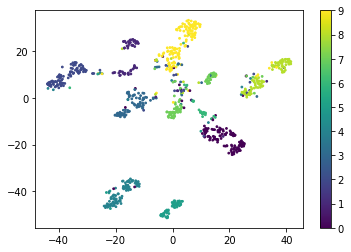

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

scatter=ax.scatter(embed_attentions[:,0], embed_attentions[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

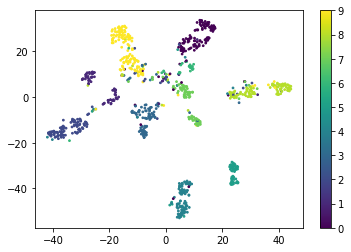

In [17]:
from umap import UMAP
mapper=UMAP()
embed_attentions=dr.fit_transform(attentions)

fig,ax=plt.subplots()

scatter=ax.scatter(embed_attentions[:,0], embed_attentions[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

## LLDL without Feature weighting

In [18]:
n_feat = train_data.shape[1]
n_attention = 10 #Reduced from 20 to 10. 10 works better
n_attention_hidden=40
n_attention_out=1
n_concat_hidden=128
n_hidden1 =64
n_hidden2 = 64
momentum=0.8
learning_rate=0.001

n_batch=8

label="SynthData"

save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewoFW",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "LocalitySensitivewoFW_{}".format(label),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="selu"
attention_hidden_activation="selu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="selu"

In [19]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy

np.random.seed(0)

input_layer=Input(shape=(n_feat, ))

attentions_layer=attention_model.ConcatAttentions(
    n_attention=n_attention,
    n_attention_hidden=n_attention_hidden,
    n_attention_out=n_attention_out,
    n_feat=n_feat,
    n_hidden=n_concat_hidden,
    activation=concat_activation, 
    kernel_initializer=kernel_initializer,
    kernel_regularizer=l2(1E-5),
    bias_regularizer=l2(1E-5),
    attention_initializer=kernel_initializer,
    attention_hidden_activation=attention_hidden_activation,
    attention_output_activation=attention_output_activation,
    batch_norm_kwargs={"trainable":False, "renorm":False},
)(input_layer)
##Removed dropout for attentions_layer because of Batch normalization
# dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(attentions_layer)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation="sigmoid")(dense_layer2)

LSwoFW_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

# loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

LSwoFW_model.compile(loss=loss_fn,
    #loss=BinaryCrossentropy(from_logits=False, 
#                                             reduction=tf.keras.losses.Reduction.AUTO,
#                                            ), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy',]
             )

In [20]:
LSwoFW_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
concat_attentions (ConcatAtt (None, 128)               6730      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 19,211
Trainable params: 18,699
Non-trainable params: 512
_________________________________________________________________


In [21]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

n_epoch=2000


LSwoFW_model.fit(train_data, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_data, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/2000
113/113 - 5s - loss: 0.7595 - accuracy: 0.4867 - val_loss: 0.7575 - val_accuracy: 0.4800

Epoch 00001: val_accuracy improved from -inf to 0.48000, saving model to 210219_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_SynthData
Epoch 2/2000
113/113 - 2s - loss: 0.7148 - accuracy: 0.5022 - val_loss: 0.7061 - val_accuracy: 0.4900

Epoch 00002: val_accuracy improved from 0.48000 to 0.49000, saving model to 210219_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_SynthData
Epoch 3/2000
113/113 - 2s - loss: 0.7011 - accuracy: 0.5356 - val_loss: 0.7030 - val_accuracy: 0.5000

Epoch 00003: val_accuracy improved from 0.49000 to 0.50000, saving model to 210219_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_SynthData
Epoch 4/2000
113/113 - 2s - loss: 0.6919 - accuracy: 0.5500 - val_loss: 0.7011 - val_accuracy: 0.5300

Epoch 00004: val_accuracy improved from 0.50000 to 0.53000, saving model to 210219_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_SynthData
Epoch 5/200


Epoch 00047: val_accuracy did not improve from 0.68000
Epoch 48/2000
113/113 - 2s - loss: 0.3040 - accuracy: 0.8678 - val_loss: 0.9519 - val_accuracy: 0.6200

Epoch 00048: val_accuracy did not improve from 0.68000
Epoch 49/2000
113/113 - 2s - loss: 0.3053 - accuracy: 0.8744 - val_loss: 1.0274 - val_accuracy: 0.5900

Epoch 00049: val_accuracy did not improve from 0.68000
Epoch 50/2000
113/113 - 2s - loss: 0.3019 - accuracy: 0.8822 - val_loss: 1.0928 - val_accuracy: 0.5900

Epoch 00050: val_accuracy did not improve from 0.68000
Epoch 51/2000
113/113 - 2s - loss: 0.2917 - accuracy: 0.8789 - val_loss: 1.0241 - val_accuracy: 0.6600

Epoch 00051: val_accuracy did not improve from 0.68000
Epoch 52/2000
113/113 - 2s - loss: 0.2950 - accuracy: 0.8789 - val_loss: 1.1129 - val_accuracy: 0.6100

Epoch 00052: val_accuracy did not improve from 0.68000
Epoch 53/2000
113/113 - 2s - loss: 0.2778 - accuracy: 0.8789 - val_loss: 1.0156 - val_accuracy: 0.6000

Epoch 00053: val_accuracy did not improve fro


Epoch 00098: val_accuracy did not improve from 0.69000
Epoch 99/2000
113/113 - 2s - loss: 0.0951 - accuracy: 0.9644 - val_loss: 1.7829 - val_accuracy: 0.6500

Epoch 00099: val_accuracy did not improve from 0.69000
Epoch 100/2000
113/113 - 2s - loss: 0.0823 - accuracy: 0.9700 - val_loss: 1.6367 - val_accuracy: 0.7300

Epoch 00100: val_accuracy improved from 0.69000 to 0.73000, saving model to 210219_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_SynthData
Epoch 101/2000
113/113 - 2s - loss: 0.1061 - accuracy: 0.9656 - val_loss: 1.8591 - val_accuracy: 0.6800

Epoch 00101: val_accuracy did not improve from 0.73000
Epoch 102/2000
113/113 - 2s - loss: 0.0750 - accuracy: 0.9744 - val_loss: 1.6451 - val_accuracy: 0.6900

Epoch 00102: val_accuracy did not improve from 0.73000
Epoch 103/2000
113/113 - 2s - loss: 0.1209 - accuracy: 0.9578 - val_loss: 1.8219 - val_accuracy: 0.6400

Epoch 00103: val_accuracy did not improve from 0.73000
Epoch 104/2000
113/113 - 2s - loss: 0.2396 - accuracy: 


Epoch 00149: val_accuracy did not improve from 0.73000
Epoch 150/2000
113/113 - 2s - loss: 0.0994 - accuracy: 0.9722 - val_loss: 2.5446 - val_accuracy: 0.6200

Epoch 00150: val_accuracy did not improve from 0.73000
Epoch 151/2000
113/113 - 2s - loss: 0.0822 - accuracy: 0.9722 - val_loss: 2.6438 - val_accuracy: 0.6100

Epoch 00151: val_accuracy did not improve from 0.73000
Epoch 152/2000
113/113 - 2s - loss: 0.0631 - accuracy: 0.9767 - val_loss: 2.2801 - val_accuracy: 0.7000

Epoch 00152: val_accuracy did not improve from 0.73000
Epoch 153/2000
113/113 - 2s - loss: 0.0970 - accuracy: 0.9678 - val_loss: 2.4816 - val_accuracy: 0.6200

Epoch 00153: val_accuracy did not improve from 0.73000
Epoch 154/2000
113/113 - 2s - loss: 0.0397 - accuracy: 0.9900 - val_loss: 2.7960 - val_accuracy: 0.6200

Epoch 00154: val_accuracy did not improve from 0.73000
Epoch 155/2000
113/113 - 2s - loss: 0.0559 - accuracy: 0.9833 - val_loss: 2.4764 - val_accuracy: 0.6800

Epoch 00155: val_accuracy did not impro

113/113 - 2s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 2.5743 - val_accuracy: 0.6300

Epoch 00201: val_accuracy did not improve from 0.73000
Epoch 202/2000
113/113 - 2s - loss: 0.0092 - accuracy: 1.0000 - val_loss: 2.5729 - val_accuracy: 0.6400

Epoch 00202: val_accuracy did not improve from 0.73000
Epoch 203/2000
113/113 - 2s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 2.5659 - val_accuracy: 0.6600

Epoch 00203: val_accuracy did not improve from 0.73000
Epoch 204/2000
113/113 - 2s - loss: 0.0089 - accuracy: 1.0000 - val_loss: 2.5630 - val_accuracy: 0.6600

Epoch 00204: val_accuracy did not improve from 0.73000
Epoch 205/2000
113/113 - 2s - loss: 0.0084 - accuracy: 1.0000 - val_loss: 2.5487 - val_accuracy: 0.6700

Epoch 00205: val_accuracy did not improve from 0.73000
Epoch 206/2000
113/113 - 2s - loss: 0.0083 - accuracy: 1.0000 - val_loss: 2.6265 - val_accuracy: 0.6400

Epoch 00206: val_accuracy did not improve from 0.73000
Epoch 207/2000
113/113 - 2s - loss: 0.0082 - accuracy: 


Epoch 00252: val_accuracy did not improve from 0.73000
Epoch 253/2000
113/113 - 2s - loss: 0.8896 - accuracy: 0.8678 - val_loss: 2.8977 - val_accuracy: 0.5600

Epoch 00253: val_accuracy did not improve from 0.73000
Epoch 254/2000
113/113 - 2s - loss: 0.5470 - accuracy: 0.8778 - val_loss: 2.2430 - val_accuracy: 0.6300

Epoch 00254: val_accuracy did not improve from 0.73000
Epoch 255/2000
113/113 - 2s - loss: 0.1473 - accuracy: 0.9478 - val_loss: 2.3043 - val_accuracy: 0.6400

Epoch 00255: val_accuracy did not improve from 0.73000
Epoch 256/2000
113/113 - 2s - loss: 0.0616 - accuracy: 0.9789 - val_loss: 2.0499 - val_accuracy: 0.6500

Epoch 00256: val_accuracy did not improve from 0.73000
Epoch 257/2000
113/113 - 2s - loss: 0.0265 - accuracy: 0.9956 - val_loss: 2.3377 - val_accuracy: 0.6200

Epoch 00257: val_accuracy did not improve from 0.73000
Epoch 258/2000
113/113 - 2s - loss: 0.0176 - accuracy: 1.0000 - val_loss: 2.2062 - val_accuracy: 0.6200

Epoch 00258: val_accuracy did not impro

113/113 - 2s - loss: 0.0083 - accuracy: 1.0000 - val_loss: 2.4521 - val_accuracy: 0.6700

Epoch 00304: val_accuracy did not improve from 0.73000
Epoch 305/2000
113/113 - 2s - loss: 0.0082 - accuracy: 1.0000 - val_loss: 2.4487 - val_accuracy: 0.6600

Epoch 00305: val_accuracy did not improve from 0.73000
Epoch 306/2000
113/113 - 2s - loss: 0.0081 - accuracy: 1.0000 - val_loss: 2.4386 - val_accuracy: 0.6700

Epoch 00306: val_accuracy did not improve from 0.73000
Epoch 307/2000
113/113 - 2s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 2.4653 - val_accuracy: 0.6600

Epoch 00307: val_accuracy did not improve from 0.73000
Epoch 308/2000
113/113 - 2s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 2.4725 - val_accuracy: 0.6600

Epoch 00308: val_accuracy did not improve from 0.73000
Epoch 309/2000
113/113 - 2s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 2.4945 - val_accuracy: 0.6600

Epoch 00309: val_accuracy did not improve from 0.73000
Epoch 310/2000
113/113 - 2s - loss: 0.0075 - accuracy: 


Epoch 00355: val_accuracy did not improve from 0.73000
Epoch 356/2000
113/113 - 2s - loss: 0.0080 - accuracy: 1.0000 - val_loss: 2.3851 - val_accuracy: 0.6500

Epoch 00356: val_accuracy did not improve from 0.73000
Epoch 357/2000
113/113 - 2s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 2.3918 - val_accuracy: 0.6600

Epoch 00357: val_accuracy did not improve from 0.73000
Epoch 358/2000
113/113 - 2s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 2.4002 - val_accuracy: 0.6400

Epoch 00358: val_accuracy did not improve from 0.73000
Epoch 359/2000
113/113 - 2s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 2.4007 - val_accuracy: 0.6600

Epoch 00359: val_accuracy did not improve from 0.73000
Epoch 360/2000
113/113 - 2s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 2.4180 - val_accuracy: 0.6600

Epoch 00360: val_accuracy did not improve from 0.73000
Epoch 361/2000
113/113 - 2s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 2.4282 - val_accuracy: 0.6600

Epoch 00361: val_accuracy did not impro

113/113 - 2s - loss: 0.0138 - accuracy: 1.0000 - val_loss: 2.2194 - val_accuracy: 0.6400

Epoch 00407: val_accuracy did not improve from 0.73000
Epoch 408/2000
113/113 - 2s - loss: 0.0117 - accuracy: 1.0000 - val_loss: 2.2582 - val_accuracy: 0.6300

Epoch 00408: val_accuracy did not improve from 0.73000
Epoch 409/2000
113/113 - 2s - loss: 0.0106 - accuracy: 1.0000 - val_loss: 2.2885 - val_accuracy: 0.6300

Epoch 00409: val_accuracy did not improve from 0.73000
Epoch 410/2000
113/113 - 2s - loss: 0.0099 - accuracy: 1.0000 - val_loss: 2.3367 - val_accuracy: 0.6300

Epoch 00410: val_accuracy did not improve from 0.73000
Epoch 411/2000
113/113 - 2s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 2.3483 - val_accuracy: 0.6300

Epoch 00411: val_accuracy did not improve from 0.73000
Epoch 412/2000
113/113 - 2s - loss: 0.0090 - accuracy: 1.0000 - val_loss: 2.3746 - val_accuracy: 0.6200

Epoch 00412: val_accuracy did not improve from 0.73000
Epoch 413/2000
113/113 - 2s - loss: 0.0086 - accuracy: 


Epoch 00458: val_accuracy did not improve from 0.73000
Epoch 459/2000
113/113 - 2s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 2.8951 - val_accuracy: 0.6400

Epoch 00459: val_accuracy did not improve from 0.73000
Epoch 460/2000
113/113 - 2s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.8865 - val_accuracy: 0.6400

Epoch 00460: val_accuracy did not improve from 0.73000
Epoch 461/2000
113/113 - 2s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.9012 - val_accuracy: 0.6400

Epoch 00461: val_accuracy did not improve from 0.73000
Epoch 462/2000
113/113 - 2s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.8945 - val_accuracy: 0.6400

Epoch 00462: val_accuracy did not improve from 0.73000
Epoch 463/2000
113/113 - 2s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 2.8367 - val_accuracy: 0.6500

Epoch 00463: val_accuracy did not improve from 0.73000
Epoch 464/2000
113/113 - 2s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 2.8485 - val_accuracy: 0.6300

Epoch 00464: val_accuracy did not impro

113/113 - 2s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 2.7455 - val_accuracy: 0.6200

Epoch 00510: val_accuracy did not improve from 0.73000
Epoch 511/2000
113/113 - 2s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 2.7707 - val_accuracy: 0.6100

Epoch 00511: val_accuracy did not improve from 0.73000
Epoch 512/2000
113/113 - 2s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 2.7603 - val_accuracy: 0.6100

Epoch 00512: val_accuracy did not improve from 0.73000
Epoch 513/2000
113/113 - 2s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.7617 - val_accuracy: 0.6200

Epoch 00513: val_accuracy did not improve from 0.73000
Epoch 514/2000
113/113 - 2s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.7980 - val_accuracy: 0.6200

Epoch 00514: val_accuracy did not improve from 0.73000
Epoch 515/2000
113/113 - 2s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 2.8169 - val_accuracy: 0.6100

Epoch 00515: val_accuracy did not improve from 0.73000
Epoch 516/2000
113/113 - 2s - loss: 0.0050 - accuracy: 


Epoch 00561: val_accuracy did not improve from 0.73000
Epoch 562/2000
113/113 - 2s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 2.7403 - val_accuracy: 0.6500

Epoch 00562: val_accuracy did not improve from 0.73000
Epoch 563/2000
113/113 - 2s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 2.7442 - val_accuracy: 0.6500

Epoch 00563: val_accuracy did not improve from 0.73000
Epoch 564/2000
113/113 - 2s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 2.7671 - val_accuracy: 0.6400

Epoch 00564: val_accuracy did not improve from 0.73000
Epoch 565/2000
113/113 - 2s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.7686 - val_accuracy: 0.6500

Epoch 00565: val_accuracy did not improve from 0.73000
Epoch 566/2000
113/113 - 2s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.7835 - val_accuracy: 0.6500

Epoch 00566: val_accuracy did not improve from 0.73000
Epoch 567/2000
113/113 - 2s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.7895 - val_accuracy: 0.6500

Epoch 00567: val_accuracy did not impro

113/113 - 2s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 2.5834 - val_accuracy: 0.6400

Epoch 00613: val_accuracy did not improve from 0.73000
Epoch 614/2000
113/113 - 2s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 2.6094 - val_accuracy: 0.6300

Epoch 00614: val_accuracy did not improve from 0.73000
Epoch 615/2000
113/113 - 2s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.6049 - val_accuracy: 0.6400

Epoch 00615: val_accuracy did not improve from 0.73000
Epoch 616/2000
113/113 - 2s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 2.6309 - val_accuracy: 0.6300

Epoch 00616: val_accuracy did not improve from 0.73000
Epoch 617/2000
113/113 - 2s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 2.6262 - val_accuracy: 0.6400

Epoch 00617: val_accuracy did not improve from 0.73000
Epoch 618/2000
113/113 - 2s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.6566 - val_accuracy: 0.6400

Epoch 00618: val_accuracy did not improve from 0.73000
Epoch 619/2000
113/113 - 2s - loss: 0.0049 - accuracy: 


Epoch 00664: val_accuracy did not improve from 0.73000
Epoch 665/2000
113/113 - 2s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 2.2779 - val_accuracy: 0.6300

Epoch 00665: val_accuracy did not improve from 0.73000
Epoch 666/2000
113/113 - 2s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 2.3028 - val_accuracy: 0.6400

Epoch 00666: val_accuracy did not improve from 0.73000
Epoch 667/2000
113/113 - 2s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 2.3057 - val_accuracy: 0.6400

Epoch 00667: val_accuracy did not improve from 0.73000
Epoch 668/2000
113/113 - 2s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 2.3287 - val_accuracy: 0.6400

Epoch 00668: val_accuracy did not improve from 0.73000
Epoch 669/2000
113/113 - 2s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 2.3555 - val_accuracy: 0.6400

Epoch 00669: val_accuracy did not improve from 0.73000
Epoch 670/2000
113/113 - 2s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 2.3541 - val_accuracy: 0.6500

Epoch 00670: val_accuracy did not impro

113/113 - 2s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.8793 - val_accuracy: 0.6500

Epoch 00716: val_accuracy did not improve from 0.73000
Epoch 717/2000
113/113 - 2s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.8606 - val_accuracy: 0.6500

Epoch 00717: val_accuracy did not improve from 0.73000
Epoch 718/2000
113/113 - 2s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.8509 - val_accuracy: 0.6600

Epoch 00718: val_accuracy did not improve from 0.73000
Epoch 719/2000
113/113 - 2s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.8923 - val_accuracy: 0.6500

Epoch 00719: val_accuracy did not improve from 0.73000
Epoch 720/2000
113/113 - 2s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.8828 - val_accuracy: 0.6500

Epoch 00720: val_accuracy did not improve from 0.73000
Epoch 721/2000
113/113 - 2s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.9311 - val_accuracy: 0.6400

Epoch 00721: val_accuracy did not improve from 0.73000
Epoch 722/2000
113/113 - 2s - loss: 0.0038 - accuracy: 


Epoch 00767: val_accuracy did not improve from 0.73000
Epoch 768/2000
113/113 - 2s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 2.8853 - val_accuracy: 0.6500

Epoch 00768: val_accuracy did not improve from 0.73000
Epoch 769/2000
113/113 - 2s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 2.8747 - val_accuracy: 0.6500

Epoch 00769: val_accuracy did not improve from 0.73000
Epoch 770/2000
113/113 - 2s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.8866 - val_accuracy: 0.6600

Epoch 00770: val_accuracy did not improve from 0.73000
Epoch 771/2000
113/113 - 2s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.8854 - val_accuracy: 0.6600

Epoch 00771: val_accuracy did not improve from 0.73000
Epoch 772/2000
113/113 - 2s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.8824 - val_accuracy: 0.6600

Epoch 00772: val_accuracy did not improve from 0.73000
Epoch 773/2000
113/113 - 2s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 2.9006 - val_accuracy: 0.6600

Epoch 00773: val_accuracy did not impro

113/113 - 2s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 2.8523 - val_accuracy: 0.6300

Epoch 00819: val_accuracy did not improve from 0.73000
Epoch 820/2000
113/113 - 2s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 2.8590 - val_accuracy: 0.6300

Epoch 00820: val_accuracy did not improve from 0.73000
Epoch 821/2000
113/113 - 2s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 2.8678 - val_accuracy: 0.6300

Epoch 00821: val_accuracy did not improve from 0.73000
Epoch 822/2000
113/113 - 2s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 2.8794 - val_accuracy: 0.6300

Epoch 00822: val_accuracy did not improve from 0.73000
Epoch 823/2000
113/113 - 2s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 2.9003 - val_accuracy: 0.6300

Epoch 00823: val_accuracy did not improve from 0.73000
Epoch 824/2000
113/113 - 2s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 2.9062 - val_accuracy: 0.6300

Epoch 00824: val_accuracy did not improve from 0.73000
Epoch 825/2000
113/113 - 2s - loss: 0.0040 - accuracy: 


Epoch 00870: val_accuracy did not improve from 0.73000
Epoch 871/2000
113/113 - 2s - loss: 0.0220 - accuracy: 0.9956 - val_loss: 2.3583 - val_accuracy: 0.6400

Epoch 00871: val_accuracy did not improve from 0.73000
Epoch 872/2000
113/113 - 2s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 2.3872 - val_accuracy: 0.6500

Epoch 00872: val_accuracy did not improve from 0.73000
Epoch 873/2000
113/113 - 2s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 2.3998 - val_accuracy: 0.6500

Epoch 00873: val_accuracy did not improve from 0.73000
Epoch 874/2000
113/113 - 2s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 2.4180 - val_accuracy: 0.6500

Epoch 00874: val_accuracy did not improve from 0.73000
Epoch 875/2000
113/113 - 2s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 2.4424 - val_accuracy: 0.6500

Epoch 00875: val_accuracy did not improve from 0.73000
Epoch 876/2000
113/113 - 2s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 2.4692 - val_accuracy: 0.6500

Epoch 00876: val_accuracy did not impro

113/113 - 2s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 3.0132 - val_accuracy: 0.6500

Epoch 00922: val_accuracy did not improve from 0.73000
Epoch 923/2000
113/113 - 2s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 3.0279 - val_accuracy: 0.6500

Epoch 00923: val_accuracy did not improve from 0.73000
Epoch 924/2000
113/113 - 2s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 3.0205 - val_accuracy: 0.6500

Epoch 00924: val_accuracy did not improve from 0.73000
Epoch 925/2000
113/113 - 2s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 3.0377 - val_accuracy: 0.6400

Epoch 00925: val_accuracy did not improve from 0.73000
Epoch 926/2000
113/113 - 2s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 3.0320 - val_accuracy: 0.6500

Epoch 00926: val_accuracy did not improve from 0.73000
Epoch 927/2000
113/113 - 2s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 3.0350 - val_accuracy: 0.6400

Epoch 00927: val_accuracy did not improve from 0.73000
Epoch 928/2000
113/113 - 2s - loss: 0.0031 - accuracy: 


Epoch 00973: val_accuracy did not improve from 0.73000
Epoch 974/2000
113/113 - 2s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 2.7474 - val_accuracy: 0.6700

Epoch 00974: val_accuracy did not improve from 0.73000
Epoch 975/2000
113/113 - 2s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 2.7513 - val_accuracy: 0.6700

Epoch 00975: val_accuracy did not improve from 0.73000
Epoch 976/2000
113/113 - 2s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.7686 - val_accuracy: 0.6700

Epoch 00976: val_accuracy did not improve from 0.73000
Epoch 977/2000
113/113 - 2s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.7769 - val_accuracy: 0.6700

Epoch 00977: val_accuracy did not improve from 0.73000
Epoch 978/2000
113/113 - 2s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.7811 - val_accuracy: 0.6700

Epoch 00978: val_accuracy did not improve from 0.73000
Epoch 979/2000
113/113 - 2s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.7854 - val_accuracy: 0.6700

Epoch 00979: val_accuracy did not impro

113/113 - 2s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.5151 - val_accuracy: 0.6300

Epoch 01025: val_accuracy did not improve from 0.73000
Epoch 1026/2000
113/113 - 2s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 2.5395 - val_accuracy: 0.6300

Epoch 01026: val_accuracy did not improve from 0.73000
Epoch 1027/2000
113/113 - 2s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 2.5559 - val_accuracy: 0.6400

Epoch 01027: val_accuracy did not improve from 0.73000
Epoch 1028/2000
113/113 - 2s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 2.5865 - val_accuracy: 0.6300

Epoch 01028: val_accuracy did not improve from 0.73000
Epoch 1029/2000
113/113 - 2s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 2.6041 - val_accuracy: 0.6300

Epoch 01029: val_accuracy did not improve from 0.73000
Epoch 1030/2000
113/113 - 2s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 2.6319 - val_accuracy: 0.6400

Epoch 01030: val_accuracy did not improve from 0.73000
Epoch 1031/2000
113/113 - 2s - loss: 0.0039 - accu

113/113 - 2s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 3.0064 - val_accuracy: 0.6500

Epoch 01076: val_accuracy did not improve from 0.73000
Epoch 1077/2000
113/113 - 2s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.9785 - val_accuracy: 0.6700

Epoch 01077: val_accuracy did not improve from 0.73000
Epoch 1078/2000
113/113 - 2s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 3.0259 - val_accuracy: 0.6700

Epoch 01078: val_accuracy did not improve from 0.73000
Epoch 1079/2000
113/113 - 2s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 3.0288 - val_accuracy: 0.6600

Epoch 01079: val_accuracy did not improve from 0.73000
Epoch 1080/2000
113/113 - 2s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 3.0019 - val_accuracy: 0.6700

Epoch 01080: val_accuracy did not improve from 0.73000
Epoch 1081/2000
113/113 - 2s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 3.0135 - val_accuracy: 0.6600

Epoch 01081: val_accuracy did not improve from 0.73000
Epoch 1082/2000
113/113 - 2s - loss: 0.0027 - accu

113/113 - 2s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 2.8934 - val_accuracy: 0.6600

Epoch 01127: val_accuracy did not improve from 0.73000
Epoch 1128/2000
113/113 - 2s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 2.8880 - val_accuracy: 0.6600

Epoch 01128: val_accuracy did not improve from 0.73000
Epoch 1129/2000
113/113 - 2s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 2.9133 - val_accuracy: 0.6700

Epoch 01129: val_accuracy did not improve from 0.73000
Epoch 1130/2000
113/113 - 2s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 2.9102 - val_accuracy: 0.6500

Epoch 01130: val_accuracy did not improve from 0.73000
Epoch 1131/2000
113/113 - 2s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 2.9208 - val_accuracy: 0.6600

Epoch 01131: val_accuracy did not improve from 0.73000
Epoch 1132/2000
113/113 - 2s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 2.9152 - val_accuracy: 0.6600

Epoch 01132: val_accuracy did not improve from 0.73000
Epoch 1133/2000
113/113 - 2s - loss: 0.0028 - accu

113/113 - 2s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 2.7693 - val_accuracy: 0.6500

Epoch 01178: val_accuracy did not improve from 0.73000
Epoch 1179/2000
113/113 - 2s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.7875 - val_accuracy: 0.6600

Epoch 01179: val_accuracy did not improve from 0.73000
Epoch 1180/2000
113/113 - 2s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.7922 - val_accuracy: 0.6600

Epoch 01180: val_accuracy did not improve from 0.73000
Epoch 1181/2000
113/113 - 2s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.8014 - val_accuracy: 0.6500

Epoch 01181: val_accuracy did not improve from 0.73000
Epoch 1182/2000
113/113 - 2s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.8105 - val_accuracy: 0.6500

Epoch 01182: val_accuracy did not improve from 0.73000
Epoch 1183/2000
113/113 - 2s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.8129 - val_accuracy: 0.6500

Epoch 01183: val_accuracy did not improve from 0.73000
Epoch 1184/2000
113/113 - 2s - loss: 0.0028 - accu

113/113 - 2s - loss: 0.0316 - accuracy: 0.9933 - val_loss: 2.3813 - val_accuracy: 0.6500

Epoch 01229: val_accuracy did not improve from 0.73000
Epoch 1230/2000
113/113 - 2s - loss: 0.0086 - accuracy: 1.0000 - val_loss: 2.4555 - val_accuracy: 0.6300

Epoch 01230: val_accuracy did not improve from 0.73000
Epoch 1231/2000
113/113 - 2s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 2.4436 - val_accuracy: 0.6600

Epoch 01231: val_accuracy did not improve from 0.73000
Epoch 1232/2000
113/113 - 2s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.4714 - val_accuracy: 0.6600

Epoch 01232: val_accuracy did not improve from 0.73000
Epoch 1233/2000
113/113 - 2s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 2.4899 - val_accuracy: 0.6600

Epoch 01233: val_accuracy did not improve from 0.73000
Epoch 1234/2000
113/113 - 2s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 2.5048 - val_accuracy: 0.6700

Epoch 01234: val_accuracy did not improve from 0.73000
Epoch 1235/2000
113/113 - 2s - loss: 0.0040 - accu

113/113 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.9454 - val_accuracy: 0.6800

Epoch 01280: val_accuracy did not improve from 0.73000
Epoch 1281/2000
113/113 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.9593 - val_accuracy: 0.6800

Epoch 01281: val_accuracy did not improve from 0.73000
Epoch 1282/2000
113/113 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.9611 - val_accuracy: 0.6800

Epoch 01282: val_accuracy did not improve from 0.73000
Epoch 1283/2000
113/113 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.9601 - val_accuracy: 0.6700

Epoch 01283: val_accuracy did not improve from 0.73000
Epoch 1284/2000
113/113 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.9808 - val_accuracy: 0.6800

Epoch 01284: val_accuracy did not improve from 0.73000
Epoch 1285/2000
113/113 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.9812 - val_accuracy: 0.6800

Epoch 01285: val_accuracy did not improve from 0.73000
Epoch 1286/2000
113/113 - 2s - loss: 0.0024 - accu

113/113 - 2s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.7740 - val_accuracy: 0.6200

Epoch 01331: val_accuracy did not improve from 0.73000
Epoch 1332/2000
113/113 - 2s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.7797 - val_accuracy: 0.6400

Epoch 01332: val_accuracy did not improve from 0.73000
Epoch 1333/2000
113/113 - 2s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 2.7878 - val_accuracy: 0.6500

Epoch 01333: val_accuracy did not improve from 0.73000
Epoch 1334/2000
113/113 - 2s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 2.7912 - val_accuracy: 0.6500

Epoch 01334: val_accuracy did not improve from 0.73000
Epoch 1335/2000
113/113 - 2s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 2.8050 - val_accuracy: 0.6400

Epoch 01335: val_accuracy did not improve from 0.73000
Epoch 1336/2000
113/113 - 2s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 2.8085 - val_accuracy: 0.6400

Epoch 01336: val_accuracy did not improve from 0.73000
Epoch 1337/2000
113/113 - 2s - loss: 0.0026 - accu

113/113 - 2s - loss: 0.9483 - accuracy: 0.8456 - val_loss: 2.3765 - val_accuracy: 0.6400

Epoch 01382: val_accuracy did not improve from 0.73000
Epoch 1383/2000
113/113 - 2s - loss: 0.1123 - accuracy: 0.9633 - val_loss: 2.5650 - val_accuracy: 0.6100

Epoch 01383: val_accuracy did not improve from 0.73000
Epoch 1384/2000
113/113 - 2s - loss: 0.0270 - accuracy: 0.9933 - val_loss: 2.5591 - val_accuracy: 0.6400

Epoch 01384: val_accuracy did not improve from 0.73000
Epoch 1385/2000
113/113 - 2s - loss: 0.0077 - accuracy: 0.9989 - val_loss: 2.5487 - val_accuracy: 0.6500

Epoch 01385: val_accuracy did not improve from 0.73000
Epoch 1386/2000
113/113 - 2s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.5579 - val_accuracy: 0.6300

Epoch 01386: val_accuracy did not improve from 0.73000
Epoch 1387/2000
113/113 - 2s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 2.5794 - val_accuracy: 0.6500

Epoch 01387: val_accuracy did not improve from 0.73000
Epoch 1388/2000
113/113 - 2s - loss: 0.0040 - accu

113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.9864 - val_accuracy: 0.6200

Epoch 01433: val_accuracy did not improve from 0.73000
Epoch 1434/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.9898 - val_accuracy: 0.6200

Epoch 01434: val_accuracy did not improve from 0.73000
Epoch 1435/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.0037 - val_accuracy: 0.6200

Epoch 01435: val_accuracy did not improve from 0.73000
Epoch 1436/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.0358 - val_accuracy: 0.6200

Epoch 01436: val_accuracy did not improve from 0.73000
Epoch 1437/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.0194 - val_accuracy: 0.6200

Epoch 01437: val_accuracy did not improve from 0.73000
Epoch 1438/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.0202 - val_accuracy: 0.6200

Epoch 01438: val_accuracy did not improve from 0.73000
Epoch 1439/2000
113/113 - 2s - loss: 0.0022 - accu

113/113 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.7017 - val_accuracy: 0.6300

Epoch 01484: val_accuracy did not improve from 0.73000
Epoch 1485/2000
113/113 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.7155 - val_accuracy: 0.6300

Epoch 01485: val_accuracy did not improve from 0.73000
Epoch 1486/2000
113/113 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.7131 - val_accuracy: 0.6300

Epoch 01486: val_accuracy did not improve from 0.73000
Epoch 1487/2000
113/113 - 2s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.7213 - val_accuracy: 0.6300

Epoch 01487: val_accuracy did not improve from 0.73000
Epoch 1488/2000
113/113 - 2s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.7225 - val_accuracy: 0.6300

Epoch 01488: val_accuracy did not improve from 0.73000
Epoch 1489/2000
113/113 - 2s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.7313 - val_accuracy: 0.6300

Epoch 01489: val_accuracy did not improve from 0.73000
Epoch 1490/2000
113/113 - 2s - loss: 0.0023 - accu

113/113 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 2.9923 - val_accuracy: 0.6200

Epoch 01535: val_accuracy did not improve from 0.73000
Epoch 1536/2000
113/113 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 2.9919 - val_accuracy: 0.6200

Epoch 01536: val_accuracy did not improve from 0.73000
Epoch 1537/2000
113/113 - 2s - loss: 0.2877 - accuracy: 0.9489 - val_loss: 3.1803 - val_accuracy: 0.6400

Epoch 01537: val_accuracy did not improve from 0.73000
Epoch 1538/2000
113/113 - 2s - loss: 0.4976 - accuracy: 0.8922 - val_loss: 2.9469 - val_accuracy: 0.6300

Epoch 01538: val_accuracy did not improve from 0.73000
Epoch 1539/2000
113/113 - 2s - loss: 0.0891 - accuracy: 0.9644 - val_loss: 2.3764 - val_accuracy: 0.6600

Epoch 01539: val_accuracy did not improve from 0.73000
Epoch 1540/2000
113/113 - 2s - loss: 0.0249 - accuracy: 0.9956 - val_loss: 2.5893 - val_accuracy: 0.6600

Epoch 01540: val_accuracy did not improve from 0.73000
Epoch 1541/2000
113/113 - 2s - loss: 0.0134 - accu

113/113 - 2s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.9691 - val_accuracy: 0.6300

Epoch 01586: val_accuracy did not improve from 0.73000
Epoch 1587/2000
113/113 - 2s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.9674 - val_accuracy: 0.6300

Epoch 01587: val_accuracy did not improve from 0.73000
Epoch 1588/2000
113/113 - 2s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.9862 - val_accuracy: 0.6200

Epoch 01588: val_accuracy did not improve from 0.73000
Epoch 1589/2000
113/113 - 2s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.9657 - val_accuracy: 0.6300

Epoch 01589: val_accuracy did not improve from 0.73000
Epoch 1590/2000
113/113 - 2s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.9718 - val_accuracy: 0.6300

Epoch 01590: val_accuracy did not improve from 0.73000
Epoch 1591/2000
113/113 - 2s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.9920 - val_accuracy: 0.6300

Epoch 01591: val_accuracy did not improve from 0.73000
Epoch 1592/2000
113/113 - 2s - loss: 0.0020 - accu

113/113 - 2s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 3.0137 - val_accuracy: 0.6200

Epoch 01637: val_accuracy did not improve from 0.73000
Epoch 1638/2000
113/113 - 2s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 3.0212 - val_accuracy: 0.6200

Epoch 01638: val_accuracy did not improve from 0.73000
Epoch 1639/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.0268 - val_accuracy: 0.6200

Epoch 01639: val_accuracy did not improve from 0.73000
Epoch 1640/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.0311 - val_accuracy: 0.6200

Epoch 01640: val_accuracy did not improve from 0.73000
Epoch 1641/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.0357 - val_accuracy: 0.6200

Epoch 01641: val_accuracy did not improve from 0.73000
Epoch 1642/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.0428 - val_accuracy: 0.6200

Epoch 01642: val_accuracy did not improve from 0.73000
Epoch 1643/2000
113/113 - 2s - loss: 0.0022 - accu

113/113 - 2s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 3.1956 - val_accuracy: 0.6300

Epoch 01688: val_accuracy did not improve from 0.73000
Epoch 1689/2000
113/113 - 2s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 3.2076 - val_accuracy: 0.6200

Epoch 01689: val_accuracy did not improve from 0.73000
Epoch 1690/2000
113/113 - 2s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 3.1775 - val_accuracy: 0.6100

Epoch 01690: val_accuracy did not improve from 0.73000
Epoch 1691/2000
113/113 - 2s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.2043 - val_accuracy: 0.6100

Epoch 01691: val_accuracy did not improve from 0.73000
Epoch 1692/2000
113/113 - 2s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.2306 - val_accuracy: 0.6100

Epoch 01692: val_accuracy did not improve from 0.73000
Epoch 1693/2000
113/113 - 2s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 3.0859 - val_accuracy: 0.6100

Epoch 01693: val_accuracy did not improve from 0.73000
Epoch 1694/2000
113/113 - 2s - loss: 0.6197 - accu

113/113 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 3.1078 - val_accuracy: 0.6400

Epoch 01739: val_accuracy did not improve from 0.73000
Epoch 1740/2000
113/113 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 3.1250 - val_accuracy: 0.6300

Epoch 01740: val_accuracy did not improve from 0.73000
Epoch 1741/2000
113/113 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 3.1333 - val_accuracy: 0.6400

Epoch 01741: val_accuracy did not improve from 0.73000
Epoch 1742/2000
113/113 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 3.1149 - val_accuracy: 0.6400

Epoch 01742: val_accuracy did not improve from 0.73000
Epoch 1743/2000
113/113 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 3.1306 - val_accuracy: 0.6400

Epoch 01743: val_accuracy did not improve from 0.73000
Epoch 1744/2000
113/113 - 2s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 3.1384 - val_accuracy: 0.6400

Epoch 01744: val_accuracy did not improve from 0.73000
Epoch 1745/2000
113/113 - 2s - loss: 0.0018 - accu

113/113 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 3.0916 - val_accuracy: 0.6100

Epoch 01790: val_accuracy did not improve from 0.73000
Epoch 1791/2000
113/113 - 2s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 3.0923 - val_accuracy: 0.6100

Epoch 01791: val_accuracy did not improve from 0.73000
Epoch 1792/2000
113/113 - 2s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 3.0963 - val_accuracy: 0.6000

Epoch 01792: val_accuracy did not improve from 0.73000
Epoch 1793/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.0932 - val_accuracy: 0.6100

Epoch 01793: val_accuracy did not improve from 0.73000
Epoch 1794/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.0923 - val_accuracy: 0.6000

Epoch 01794: val_accuracy did not improve from 0.73000
Epoch 1795/2000
113/113 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.0947 - val_accuracy: 0.6000

Epoch 01795: val_accuracy did not improve from 0.73000
Epoch 1796/2000
113/113 - 2s - loss: 0.0021 - accu

113/113 - 2s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.3056 - val_accuracy: 0.6200

Epoch 01841: val_accuracy did not improve from 0.73000
Epoch 1842/2000
113/113 - 2s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.3034 - val_accuracy: 0.6100

Epoch 01842: val_accuracy did not improve from 0.73000
Epoch 1843/2000
113/113 - 2s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.2839 - val_accuracy: 0.6200

Epoch 01843: val_accuracy did not improve from 0.73000
Epoch 1844/2000
113/113 - 2s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.3166 - val_accuracy: 0.6200

Epoch 01844: val_accuracy did not improve from 0.73000
Epoch 1845/2000
113/113 - 2s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.3110 - val_accuracy: 0.6200

Epoch 01845: val_accuracy did not improve from 0.73000
Epoch 1846/2000
113/113 - 2s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.3049 - val_accuracy: 0.6100

Epoch 01846: val_accuracy did not improve from 0.73000
Epoch 1847/2000
113/113 - 2s - loss: 0.0016 - accu

113/113 - 2s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 3.1944 - val_accuracy: 0.6400

Epoch 01892: val_accuracy did not improve from 0.73000
Epoch 1893/2000
113/113 - 2s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.2087 - val_accuracy: 0.6400

Epoch 01893: val_accuracy did not improve from 0.73000
Epoch 1894/2000
113/113 - 2s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.2049 - val_accuracy: 0.6400

Epoch 01894: val_accuracy did not improve from 0.73000
Epoch 1895/2000
113/113 - 2s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.2218 - val_accuracy: 0.6400

Epoch 01895: val_accuracy did not improve from 0.73000
Epoch 1896/2000
113/113 - 2s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.2155 - val_accuracy: 0.6400

Epoch 01896: val_accuracy did not improve from 0.73000
Epoch 1897/2000
113/113 - 2s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.2296 - val_accuracy: 0.6400

Epoch 01897: val_accuracy did not improve from 0.73000
Epoch 1898/2000
113/113 - 2s - loss: 0.0017 - accu

113/113 - 2s - loss: 0.0112 - accuracy: 0.9967 - val_loss: 3.1033 - val_accuracy: 0.6000

Epoch 01943: val_accuracy did not improve from 0.73000
Epoch 1944/2000
113/113 - 2s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 3.0574 - val_accuracy: 0.5800

Epoch 01944: val_accuracy did not improve from 0.73000
Epoch 1945/2000
113/113 - 2s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 3.0741 - val_accuracy: 0.5800

Epoch 01945: val_accuracy did not improve from 0.73000
Epoch 1946/2000
113/113 - 2s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 3.1027 - val_accuracy: 0.5800

Epoch 01946: val_accuracy did not improve from 0.73000
Epoch 1947/2000
113/113 - 2s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 3.1036 - val_accuracy: 0.5800

Epoch 01947: val_accuracy did not improve from 0.73000
Epoch 1948/2000
113/113 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 3.1034 - val_accuracy: 0.5800

Epoch 01948: val_accuracy did not improve from 0.73000
Epoch 1949/2000
113/113 - 2s - loss: 0.0023 - accu

113/113 - 2s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.2761 - val_accuracy: 0.6100

Epoch 01994: val_accuracy did not improve from 0.73000
Epoch 1995/2000
113/113 - 2s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.2854 - val_accuracy: 0.6100

Epoch 01995: val_accuracy did not improve from 0.73000
Epoch 1996/2000
113/113 - 2s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.2885 - val_accuracy: 0.6100

Epoch 01996: val_accuracy did not improve from 0.73000
Epoch 1997/2000
113/113 - 2s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.2782 - val_accuracy: 0.6100

Epoch 01997: val_accuracy did not improve from 0.73000
Epoch 1998/2000
113/113 - 2s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.2974 - val_accuracy: 0.6100

Epoch 01998: val_accuracy did not improve from 0.73000
Epoch 1999/2000
113/113 - 2s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.2946 - val_accuracy: 0.6100

Epoch 01999: val_accuracy did not improve from 0.73000
Epoch 2000/2000
113/113 - 2s - loss: 0.0015 - accu

In [40]:
LSwoFW_model.load_weights(os.path.join("210210_TrainingLocalitySensitivewoFW",
                                      "LocalitySensitivewoFW_label" ))

In [41]:
attentions=[LSwoFW_model.layers[1].attention_layers[i](train_data).numpy() for i in range(10)]
attentions=np.reshape(attentions, (900,10))

In [22]:
attentions=LSwoFW_model.layers[1](train_data).numpy()

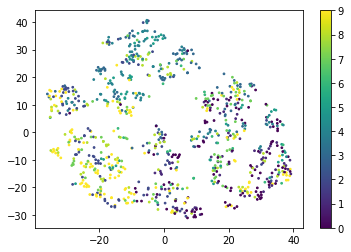

In [23]:
from sklearn.manifold import TSNE
dr=TSNE()
embed_attentions=dr.fit_transform(attentions)

%matplotlib inline
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

scatter=ax.scatter(embed_attentions[:,0], embed_attentions[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

## Dense model

In [24]:
n_feat = train_data.shape[1]
n_attention = 10 #Reduced from 20 to 10. 10 works better
n_attention_hidden=40
n_attention_out=1
n_concat_hidden=128
n_hidden1 =64
n_hidden2 = 64
momentum=0.8
learning_rate=0.001

n_batch=8

label="SynthData"

save_folder=os.path.join(time.strftime("%y%m%d_TrainingDense",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "Dense_{}".format("label"),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="selu"
attention_hidden_activation="selu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="selu"

In [25]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy

np.random.seed(0)

input_layer=Input(shape=(n_feat, ))

dense_layer0=Dense(n_attention_hidden*n_attention,
                   activation="sigmoid", 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(input_layer)
# attentions_layer=attention_model.ConcatAttentions(
#     n_attention=n_attention,
#     n_attention_hidden=n_attention_hidden,
#     n_attention_out=n_attention_out,
#     n_feat=n_feat,
#     n_hidden=n_concat_hidden,
#     activation=concat_activation, 
#     kernel_initializer=kernel_initializer,
#     kernel_regularizer=l2(1E-5),
#     bias_regularizer=l2(1E-5),
#     attention_initializer=kernel_initializer,
#     attention_hidden_activation=attention_hidden_activation,
#     attention_output_activation=attention_output_activation,
#     batch_norm_kwargs={"trainable":False, "renorm":False},
# )(input_layer)
##Removed dropout for attentions_layer because of Batch normalization
# dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(dense_layer0)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation="sigmoid")(dense_layer2)

dense_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

# loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

dense_model.compile(loss=loss_fn,
    #loss=BinaryCrossentropy(from_logits=False, 
#                                             reduction=tf.keras.losses.Reduction.AUTO,
#                                            ), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy',]
             )

In [26]:
dense_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 400)               4400      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                25664     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 34,289
Trainable params: 34,289
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

n_epoch=2000


dense_model.fit(train_data, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_data, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/2000
113/113 - 1s - loss: 0.7663 - accuracy: 0.4722 - val_loss: 0.7422 - val_accuracy: 0.4800

Epoch 00001: val_accuracy improved from -inf to 0.48000, saving model to 210219_TrainingDense\Dense_label
Epoch 2/2000
113/113 - 1s - loss: 0.7212 - accuracy: 0.5178 - val_loss: 0.7377 - val_accuracy: 0.5200

Epoch 00002: val_accuracy improved from 0.48000 to 0.52000, saving model to 210219_TrainingDense\Dense_label
Epoch 3/2000
113/113 - 1s - loss: 0.7181 - accuracy: 0.4711 - val_loss: 0.7076 - val_accuracy: 0.4500

Epoch 00003: val_accuracy did not improve from 0.52000
Epoch 4/2000
113/113 - 1s - loss: 0.7005 - accuracy: 0.5344 - val_loss: 0.7372 - val_accuracy: 0.4800

Epoch 00004: val_accuracy did not improve from 0.52000
Epoch 5/2000
113/113 - 1s - loss: 0.7177 - accuracy: 0.5011 - val_loss: 0.7127 - val_accuracy: 0.4700

Epoch 00005: val_accuracy did not improve from 0.52000
Epoch 6/2000
113/113 - 1s - loss: 0.7135 - accuracy: 0.5044 - val_loss: 0.7233 - val_accuracy: 0.4200

Ep

113/113 - 1s - loss: 0.4957 - accuracy: 0.7622 - val_loss: 0.7763 - val_accuracy: 0.6300

Epoch 00050: val_accuracy did not improve from 0.67000
Epoch 51/2000
113/113 - 1s - loss: 0.4801 - accuracy: 0.7667 - val_loss: 0.6675 - val_accuracy: 0.7100

Epoch 00051: val_accuracy improved from 0.67000 to 0.71000, saving model to 210219_TrainingDense\Dense_label
Epoch 52/2000
113/113 - 1s - loss: 0.4819 - accuracy: 0.7700 - val_loss: 0.8231 - val_accuracy: 0.5600

Epoch 00052: val_accuracy did not improve from 0.71000
Epoch 53/2000
113/113 - 1s - loss: 0.4628 - accuracy: 0.7989 - val_loss: 0.7567 - val_accuracy: 0.6800

Epoch 00053: val_accuracy did not improve from 0.71000
Epoch 54/2000
113/113 - 1s - loss: 0.4940 - accuracy: 0.7433 - val_loss: 0.7015 - val_accuracy: 0.6400

Epoch 00054: val_accuracy did not improve from 0.71000
Epoch 55/2000
113/113 - 1s - loss: 0.4509 - accuracy: 0.8011 - val_loss: 0.7274 - val_accuracy: 0.6400

Epoch 00055: val_accuracy did not improve from 0.71000
Epoch 


Epoch 00101: val_accuracy did not improve from 0.71000
Epoch 102/2000
113/113 - 1s - loss: 0.1419 - accuracy: 0.9667 - val_loss: 1.3992 - val_accuracy: 0.6100

Epoch 00102: val_accuracy did not improve from 0.71000
Epoch 103/2000
113/113 - 1s - loss: 0.1620 - accuracy: 0.9478 - val_loss: 1.3686 - val_accuracy: 0.6000

Epoch 00103: val_accuracy did not improve from 0.71000
Epoch 104/2000
113/113 - 1s - loss: 0.1614 - accuracy: 0.9367 - val_loss: 1.3560 - val_accuracy: 0.6300

Epoch 00104: val_accuracy did not improve from 0.71000
Epoch 105/2000
113/113 - 1s - loss: 0.1366 - accuracy: 0.9578 - val_loss: 1.4247 - val_accuracy: 0.5800

Epoch 00105: val_accuracy did not improve from 0.71000
Epoch 106/2000
113/113 - 1s - loss: 0.1379 - accuracy: 0.9667 - val_loss: 1.3834 - val_accuracy: 0.6200

Epoch 00106: val_accuracy did not improve from 0.71000
Epoch 107/2000
113/113 - 1s - loss: 0.1242 - accuracy: 0.9656 - val_loss: 1.3345 - val_accuracy: 0.6300

Epoch 00107: val_accuracy did not impro

113/113 - 1s - loss: 0.0282 - accuracy: 1.0000 - val_loss: 2.2135 - val_accuracy: 0.5800

Epoch 00153: val_accuracy did not improve from 0.71000
Epoch 154/2000
113/113 - 1s - loss: 0.0266 - accuracy: 1.0000 - val_loss: 2.1764 - val_accuracy: 0.6200

Epoch 00154: val_accuracy did not improve from 0.71000
Epoch 155/2000
113/113 - 1s - loss: 0.0263 - accuracy: 1.0000 - val_loss: 2.1810 - val_accuracy: 0.6200

Epoch 00155: val_accuracy did not improve from 0.71000
Epoch 156/2000
113/113 - 1s - loss: 0.0258 - accuracy: 1.0000 - val_loss: 2.2217 - val_accuracy: 0.6100

Epoch 00156: val_accuracy did not improve from 0.71000
Epoch 157/2000
113/113 - 1s - loss: 0.0256 - accuracy: 1.0000 - val_loss: 2.2496 - val_accuracy: 0.5800

Epoch 00157: val_accuracy did not improve from 0.71000
Epoch 158/2000
113/113 - 1s - loss: 0.0254 - accuracy: 1.0000 - val_loss: 2.2421 - val_accuracy: 0.5900

Epoch 00158: val_accuracy did not improve from 0.71000
Epoch 159/2000
113/113 - 1s - loss: 0.0252 - accuracy: 


Epoch 00204: val_accuracy did not improve from 0.71000
Epoch 205/2000
113/113 - 1s - loss: 0.0228 - accuracy: 1.0000 - val_loss: 2.4598 - val_accuracy: 0.5800

Epoch 00205: val_accuracy did not improve from 0.71000
Epoch 206/2000
113/113 - 1s - loss: 0.0227 - accuracy: 1.0000 - val_loss: 2.4905 - val_accuracy: 0.6000

Epoch 00206: val_accuracy did not improve from 0.71000
Epoch 207/2000
113/113 - 1s - loss: 0.0296 - accuracy: 0.9989 - val_loss: 2.5203 - val_accuracy: 0.6600

Epoch 00207: val_accuracy did not improve from 0.71000
Epoch 208/2000
113/113 - 1s - loss: 0.7347 - accuracy: 0.8267 - val_loss: 3.2812 - val_accuracy: 0.5000

Epoch 00208: val_accuracy did not improve from 0.71000
Epoch 209/2000
113/113 - 1s - loss: 0.3171 - accuracy: 0.9122 - val_loss: 2.2199 - val_accuracy: 0.6400

Epoch 00209: val_accuracy did not improve from 0.71000
Epoch 210/2000
113/113 - 1s - loss: 0.1002 - accuracy: 0.9733 - val_loss: 2.5066 - val_accuracy: 0.5800

Epoch 00210: val_accuracy did not impro

113/113 - 1s - loss: 0.0246 - accuracy: 1.0000 - val_loss: 2.7198 - val_accuracy: 0.6000

Epoch 00256: val_accuracy did not improve from 0.71000
Epoch 257/2000
113/113 - 1s - loss: 0.0243 - accuracy: 1.0000 - val_loss: 2.7132 - val_accuracy: 0.6100

Epoch 00257: val_accuracy did not improve from 0.71000
Epoch 258/2000
113/113 - 1s - loss: 0.0240 - accuracy: 1.0000 - val_loss: 2.7191 - val_accuracy: 0.6100

Epoch 00258: val_accuracy did not improve from 0.71000
Epoch 259/2000
113/113 - 1s - loss: 0.0238 - accuracy: 1.0000 - val_loss: 2.7594 - val_accuracy: 0.6000

Epoch 00259: val_accuracy did not improve from 0.71000
Epoch 260/2000
113/113 - 1s - loss: 0.0236 - accuracy: 1.0000 - val_loss: 2.7436 - val_accuracy: 0.6100

Epoch 00260: val_accuracy did not improve from 0.71000
Epoch 261/2000
113/113 - 1s - loss: 0.0235 - accuracy: 1.0000 - val_loss: 2.7628 - val_accuracy: 0.6200

Epoch 00261: val_accuracy did not improve from 0.71000
Epoch 262/2000
113/113 - 1s - loss: 0.0234 - accuracy: 


Epoch 00307: val_accuracy did not improve from 0.71000
Epoch 308/2000
113/113 - 1s - loss: 0.0228 - accuracy: 1.0000 - val_loss: 2.7151 - val_accuracy: 0.6400

Epoch 00308: val_accuracy did not improve from 0.71000
Epoch 309/2000
113/113 - 1s - loss: 0.0227 - accuracy: 1.0000 - val_loss: 2.7216 - val_accuracy: 0.6300

Epoch 00309: val_accuracy did not improve from 0.71000
Epoch 310/2000
113/113 - 1s - loss: 0.0226 - accuracy: 1.0000 - val_loss: 2.7332 - val_accuracy: 0.6300

Epoch 00310: val_accuracy did not improve from 0.71000
Epoch 311/2000
113/113 - 1s - loss: 0.0225 - accuracy: 1.0000 - val_loss: 2.7406 - val_accuracy: 0.6300

Epoch 00311: val_accuracy did not improve from 0.71000
Epoch 312/2000
113/113 - 1s - loss: 0.0223 - accuracy: 1.0000 - val_loss: 2.7279 - val_accuracy: 0.6200

Epoch 00312: val_accuracy did not improve from 0.71000
Epoch 313/2000
113/113 - 1s - loss: 0.0223 - accuracy: 1.0000 - val_loss: 2.7490 - val_accuracy: 0.6200

Epoch 00313: val_accuracy did not impro

113/113 - 1s - loss: 0.0218 - accuracy: 1.0000 - val_loss: 2.7292 - val_accuracy: 0.6100

Epoch 00359: val_accuracy did not improve from 0.71000
Epoch 360/2000
113/113 - 1s - loss: 0.0216 - accuracy: 1.0000 - val_loss: 2.7446 - val_accuracy: 0.6200

Epoch 00360: val_accuracy did not improve from 0.71000
Epoch 361/2000
113/113 - 1s - loss: 0.0216 - accuracy: 1.0000 - val_loss: 2.7123 - val_accuracy: 0.6200

Epoch 00361: val_accuracy did not improve from 0.71000
Epoch 362/2000
113/113 - 1s - loss: 0.0215 - accuracy: 1.0000 - val_loss: 2.7188 - val_accuracy: 0.6100

Epoch 00362: val_accuracy did not improve from 0.71000
Epoch 363/2000
113/113 - 1s - loss: 0.0213 - accuracy: 1.0000 - val_loss: 2.7649 - val_accuracy: 0.6200

Epoch 00363: val_accuracy did not improve from 0.71000
Epoch 364/2000
113/113 - 1s - loss: 0.0212 - accuracy: 1.0000 - val_loss: 2.7577 - val_accuracy: 0.6100

Epoch 00364: val_accuracy did not improve from 0.71000
Epoch 365/2000
113/113 - 1s - loss: 0.0211 - accuracy: 


Epoch 00410: val_accuracy did not improve from 0.71000
Epoch 411/2000
113/113 - 1s - loss: 0.0202 - accuracy: 1.0000 - val_loss: 2.6463 - val_accuracy: 0.6000

Epoch 00411: val_accuracy did not improve from 0.71000
Epoch 412/2000
113/113 - 1s - loss: 0.0201 - accuracy: 1.0000 - val_loss: 2.6796 - val_accuracy: 0.6100

Epoch 00412: val_accuracy did not improve from 0.71000
Epoch 413/2000
113/113 - 1s - loss: 0.0200 - accuracy: 1.0000 - val_loss: 2.6934 - val_accuracy: 0.6200

Epoch 00413: val_accuracy did not improve from 0.71000
Epoch 414/2000
113/113 - 1s - loss: 0.0199 - accuracy: 1.0000 - val_loss: 2.7008 - val_accuracy: 0.6000

Epoch 00414: val_accuracy did not improve from 0.71000
Epoch 415/2000
113/113 - 1s - loss: 0.0199 - accuracy: 1.0000 - val_loss: 2.6994 - val_accuracy: 0.5900

Epoch 00415: val_accuracy did not improve from 0.71000
Epoch 416/2000
113/113 - 1s - loss: 0.0198 - accuracy: 1.0000 - val_loss: 2.7447 - val_accuracy: 0.6100

Epoch 00416: val_accuracy did not impro

113/113 - 1s - loss: 0.0204 - accuracy: 1.0000 - val_loss: 2.4936 - val_accuracy: 0.6500

Epoch 00462: val_accuracy did not improve from 0.71000
Epoch 463/2000
113/113 - 1s - loss: 0.0203 - accuracy: 1.0000 - val_loss: 2.5164 - val_accuracy: 0.6600

Epoch 00463: val_accuracy did not improve from 0.71000
Epoch 464/2000
113/113 - 1s - loss: 0.0202 - accuracy: 1.0000 - val_loss: 2.5597 - val_accuracy: 0.6600

Epoch 00464: val_accuracy did not improve from 0.71000
Epoch 465/2000
113/113 - 1s - loss: 0.0201 - accuracy: 1.0000 - val_loss: 2.5950 - val_accuracy: 0.6600

Epoch 00465: val_accuracy did not improve from 0.71000
Epoch 466/2000
113/113 - 1s - loss: 0.0200 - accuracy: 1.0000 - val_loss: 2.6022 - val_accuracy: 0.6600

Epoch 00466: val_accuracy did not improve from 0.71000
Epoch 467/2000
113/113 - 1s - loss: 0.0199 - accuracy: 1.0000 - val_loss: 2.6138 - val_accuracy: 0.6600

Epoch 00467: val_accuracy did not improve from 0.71000
Epoch 468/2000
113/113 - 1s - loss: 0.0197 - accuracy: 


Epoch 00513: val_accuracy did not improve from 0.71000
Epoch 514/2000
113/113 - 1s - loss: 0.0191 - accuracy: 1.0000 - val_loss: 2.7978 - val_accuracy: 0.6100

Epoch 00514: val_accuracy did not improve from 0.71000
Epoch 515/2000
113/113 - 1s - loss: 0.0190 - accuracy: 1.0000 - val_loss: 2.7947 - val_accuracy: 0.6300

Epoch 00515: val_accuracy did not improve from 0.71000
Epoch 516/2000
113/113 - 1s - loss: 0.0189 - accuracy: 1.0000 - val_loss: 2.7976 - val_accuracy: 0.6100

Epoch 00516: val_accuracy did not improve from 0.71000
Epoch 517/2000
113/113 - 1s - loss: 0.0188 - accuracy: 1.0000 - val_loss: 2.7858 - val_accuracy: 0.6100

Epoch 00517: val_accuracy did not improve from 0.71000
Epoch 518/2000
113/113 - 1s - loss: 0.0188 - accuracy: 1.0000 - val_loss: 2.7926 - val_accuracy: 0.6300

Epoch 00518: val_accuracy did not improve from 0.71000
Epoch 519/2000
113/113 - 1s - loss: 0.0187 - accuracy: 1.0000 - val_loss: 2.8086 - val_accuracy: 0.6300

Epoch 00519: val_accuracy did not impro

113/113 - 1s - loss: 0.0186 - accuracy: 1.0000 - val_loss: 2.7142 - val_accuracy: 0.6300

Epoch 00565: val_accuracy did not improve from 0.71000
Epoch 566/2000
113/113 - 1s - loss: 0.0186 - accuracy: 1.0000 - val_loss: 2.7261 - val_accuracy: 0.6300

Epoch 00566: val_accuracy did not improve from 0.71000
Epoch 567/2000
113/113 - 1s - loss: 0.0185 - accuracy: 1.0000 - val_loss: 2.7360 - val_accuracy: 0.6200

Epoch 00567: val_accuracy did not improve from 0.71000
Epoch 568/2000
113/113 - 1s - loss: 0.0184 - accuracy: 1.0000 - val_loss: 2.6987 - val_accuracy: 0.6100

Epoch 00568: val_accuracy did not improve from 0.71000
Epoch 569/2000
113/113 - 1s - loss: 0.0184 - accuracy: 1.0000 - val_loss: 2.7614 - val_accuracy: 0.6300

Epoch 00569: val_accuracy did not improve from 0.71000
Epoch 570/2000
113/113 - 1s - loss: 0.0183 - accuracy: 1.0000 - val_loss: 2.7533 - val_accuracy: 0.6200

Epoch 00570: val_accuracy did not improve from 0.71000
Epoch 571/2000
113/113 - 1s - loss: 0.0182 - accuracy: 


Epoch 00616: val_accuracy did not improve from 0.71000
Epoch 617/2000
113/113 - 1s - loss: 0.0176 - accuracy: 1.0000 - val_loss: 2.8625 - val_accuracy: 0.6300

Epoch 00617: val_accuracy did not improve from 0.71000
Epoch 618/2000
113/113 - 1s - loss: 0.0175 - accuracy: 1.0000 - val_loss: 2.8135 - val_accuracy: 0.6200

Epoch 00618: val_accuracy did not improve from 0.71000
Epoch 619/2000
113/113 - 1s - loss: 0.0175 - accuracy: 1.0000 - val_loss: 2.8580 - val_accuracy: 0.6000

Epoch 00619: val_accuracy did not improve from 0.71000
Epoch 620/2000
113/113 - 1s - loss: 0.0174 - accuracy: 1.0000 - val_loss: 2.8503 - val_accuracy: 0.6200

Epoch 00620: val_accuracy did not improve from 0.71000
Epoch 621/2000
113/113 - 1s - loss: 0.0173 - accuracy: 1.0000 - val_loss: 2.8119 - val_accuracy: 0.6300

Epoch 00621: val_accuracy did not improve from 0.71000
Epoch 622/2000
113/113 - 1s - loss: 0.0172 - accuracy: 1.0000 - val_loss: 2.8493 - val_accuracy: 0.6300

Epoch 00622: val_accuracy did not impro

113/113 - 1s - loss: 0.0170 - accuracy: 1.0000 - val_loss: 2.8414 - val_accuracy: 0.6100

Epoch 00668: val_accuracy did not improve from 0.71000
Epoch 669/2000
113/113 - 1s - loss: 0.0169 - accuracy: 1.0000 - val_loss: 2.8903 - val_accuracy: 0.6100

Epoch 00669: val_accuracy did not improve from 0.71000
Epoch 670/2000
113/113 - 1s - loss: 0.0169 - accuracy: 1.0000 - val_loss: 2.8185 - val_accuracy: 0.6100

Epoch 00670: val_accuracy did not improve from 0.71000
Epoch 671/2000
113/113 - 1s - loss: 0.0168 - accuracy: 1.0000 - val_loss: 2.7959 - val_accuracy: 0.6200

Epoch 00671: val_accuracy did not improve from 0.71000
Epoch 672/2000
113/113 - 1s - loss: 0.0168 - accuracy: 1.0000 - val_loss: 2.8766 - val_accuracy: 0.6100

Epoch 00672: val_accuracy did not improve from 0.71000
Epoch 673/2000
113/113 - 1s - loss: 0.0167 - accuracy: 1.0000 - val_loss: 2.8870 - val_accuracy: 0.6100

Epoch 00673: val_accuracy did not improve from 0.71000
Epoch 674/2000
113/113 - 1s - loss: 0.0166 - accuracy: 


Epoch 00719: val_accuracy did not improve from 0.71000
Epoch 720/2000
113/113 - 1s - loss: 0.0167 - accuracy: 1.0000 - val_loss: 2.7975 - val_accuracy: 0.6200

Epoch 00720: val_accuracy did not improve from 0.71000
Epoch 721/2000
113/113 - 1s - loss: 0.0167 - accuracy: 1.0000 - val_loss: 2.8161 - val_accuracy: 0.6300

Epoch 00721: val_accuracy did not improve from 0.71000
Epoch 722/2000
113/113 - 1s - loss: 0.0166 - accuracy: 1.0000 - val_loss: 2.8103 - val_accuracy: 0.6300

Epoch 00722: val_accuracy did not improve from 0.71000
Epoch 723/2000
113/113 - 1s - loss: 0.0166 - accuracy: 1.0000 - val_loss: 2.8173 - val_accuracy: 0.6300

Epoch 00723: val_accuracy did not improve from 0.71000
Epoch 724/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.8126 - val_accuracy: 0.6300

Epoch 00724: val_accuracy did not improve from 0.71000
Epoch 725/2000
113/113 - 1s - loss: 0.3718 - accuracy: 0.9489 - val_loss: 2.9391 - val_accuracy: 0.6400

Epoch 00725: val_accuracy did not impro

113/113 - 1s - loss: 0.0165 - accuracy: 1.0000 - val_loss: 2.7609 - val_accuracy: 0.6300

Epoch 00771: val_accuracy did not improve from 0.71000
Epoch 772/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.7233 - val_accuracy: 0.6300

Epoch 00772: val_accuracy did not improve from 0.71000
Epoch 773/2000
113/113 - 1s - loss: 0.0163 - accuracy: 1.0000 - val_loss: 2.7769 - val_accuracy: 0.6300

Epoch 00773: val_accuracy did not improve from 0.71000
Epoch 774/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 2.8076 - val_accuracy: 0.6200

Epoch 00774: val_accuracy did not improve from 0.71000
Epoch 775/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 2.8176 - val_accuracy: 0.6200

Epoch 00775: val_accuracy did not improve from 0.71000
Epoch 776/2000
113/113 - 1s - loss: 0.2819 - accuracy: 0.9533 - val_loss: 2.7317 - val_accuracy: 0.6400

Epoch 00776: val_accuracy did not improve from 0.71000
Epoch 777/2000
113/113 - 1s - loss: 1.2825 - accuracy: 


Epoch 00822: val_accuracy did not improve from 0.71000
Epoch 823/2000
113/113 - 1s - loss: 0.0636 - accuracy: 0.9878 - val_loss: 3.8808 - val_accuracy: 0.5900

Epoch 00823: val_accuracy did not improve from 0.71000
Epoch 824/2000
113/113 - 1s - loss: 0.8224 - accuracy: 0.8156 - val_loss: 2.4898 - val_accuracy: 0.5700

Epoch 00824: val_accuracy did not improve from 0.71000
Epoch 825/2000
113/113 - 1s - loss: 0.1830 - accuracy: 0.9333 - val_loss: 2.6883 - val_accuracy: 0.6100

Epoch 00825: val_accuracy did not improve from 0.71000
Epoch 826/2000
113/113 - 1s - loss: 0.0690 - accuracy: 0.9778 - val_loss: 2.4870 - val_accuracy: 0.6300

Epoch 00826: val_accuracy did not improve from 0.71000
Epoch 827/2000
113/113 - 1s - loss: 0.0420 - accuracy: 0.9922 - val_loss: 2.5243 - val_accuracy: 0.6100

Epoch 00827: val_accuracy did not improve from 0.71000
Epoch 828/2000
113/113 - 1s - loss: 0.0255 - accuracy: 0.9989 - val_loss: 2.6391 - val_accuracy: 0.6100

Epoch 00828: val_accuracy did not impro

113/113 - 1s - loss: 0.6312 - accuracy: 0.8533 - val_loss: 2.0260 - val_accuracy: 0.6000

Epoch 00874: val_accuracy did not improve from 0.71000
Epoch 875/2000
113/113 - 1s - loss: 0.3818 - accuracy: 0.8800 - val_loss: 2.2041 - val_accuracy: 0.6400

Epoch 00875: val_accuracy did not improve from 0.71000
Epoch 876/2000
113/113 - 1s - loss: 0.1296 - accuracy: 0.9600 - val_loss: 2.3828 - val_accuracy: 0.5900

Epoch 00876: val_accuracy did not improve from 0.71000
Epoch 877/2000
113/113 - 1s - loss: 0.0516 - accuracy: 0.9900 - val_loss: 2.4683 - val_accuracy: 0.6200

Epoch 00877: val_accuracy did not improve from 0.71000
Epoch 878/2000
113/113 - 1s - loss: 0.0542 - accuracy: 0.9856 - val_loss: 2.6147 - val_accuracy: 0.6100

Epoch 00878: val_accuracy did not improve from 0.71000
Epoch 879/2000
113/113 - 1s - loss: 0.0295 - accuracy: 0.9978 - val_loss: 2.5750 - val_accuracy: 0.6000

Epoch 00879: val_accuracy did not improve from 0.71000
Epoch 880/2000
113/113 - 1s - loss: 0.0217 - accuracy: 


Epoch 00925: val_accuracy did not improve from 0.71000
Epoch 926/2000
113/113 - 1s - loss: 0.0276 - accuracy: 1.0000 - val_loss: 2.4146 - val_accuracy: 0.6100

Epoch 00926: val_accuracy did not improve from 0.71000
Epoch 927/2000
113/113 - 1s - loss: 0.0215 - accuracy: 1.0000 - val_loss: 2.4426 - val_accuracy: 0.6200

Epoch 00927: val_accuracy did not improve from 0.71000
Epoch 928/2000
113/113 - 1s - loss: 0.0203 - accuracy: 1.0000 - val_loss: 2.4910 - val_accuracy: 0.6100

Epoch 00928: val_accuracy did not improve from 0.71000
Epoch 929/2000
113/113 - 1s - loss: 0.0195 - accuracy: 1.0000 - val_loss: 2.5432 - val_accuracy: 0.6000

Epoch 00929: val_accuracy did not improve from 0.71000
Epoch 930/2000
113/113 - 1s - loss: 0.0191 - accuracy: 1.0000 - val_loss: 2.5804 - val_accuracy: 0.6100

Epoch 00930: val_accuracy did not improve from 0.71000
Epoch 931/2000
113/113 - 1s - loss: 0.0189 - accuracy: 1.0000 - val_loss: 2.5780 - val_accuracy: 0.6200

Epoch 00931: val_accuracy did not impro

113/113 - 1s - loss: 0.0182 - accuracy: 1.0000 - val_loss: 2.6877 - val_accuracy: 0.5600

Epoch 00977: val_accuracy did not improve from 0.71000
Epoch 978/2000
113/113 - 1s - loss: 0.0181 - accuracy: 1.0000 - val_loss: 2.6625 - val_accuracy: 0.5800

Epoch 00978: val_accuracy did not improve from 0.71000
Epoch 979/2000
113/113 - 1s - loss: 0.0179 - accuracy: 1.0000 - val_loss: 2.6999 - val_accuracy: 0.5700

Epoch 00979: val_accuracy did not improve from 0.71000
Epoch 980/2000
113/113 - 1s - loss: 0.0178 - accuracy: 1.0000 - val_loss: 2.6571 - val_accuracy: 0.5800

Epoch 00980: val_accuracy did not improve from 0.71000
Epoch 981/2000
113/113 - 1s - loss: 0.0177 - accuracy: 1.0000 - val_loss: 2.7003 - val_accuracy: 0.5800

Epoch 00981: val_accuracy did not improve from 0.71000
Epoch 982/2000
113/113 - 1s - loss: 0.0175 - accuracy: 1.0000 - val_loss: 2.7100 - val_accuracy: 0.5700

Epoch 00982: val_accuracy did not improve from 0.71000
Epoch 983/2000
113/113 - 1s - loss: 0.0175 - accuracy: 


Epoch 01028: val_accuracy did not improve from 0.71000
Epoch 1029/2000
113/113 - 1s - loss: 0.0175 - accuracy: 1.0000 - val_loss: 2.5191 - val_accuracy: 0.6000

Epoch 01029: val_accuracy did not improve from 0.71000
Epoch 1030/2000
113/113 - 1s - loss: 0.0174 - accuracy: 1.0000 - val_loss: 2.5403 - val_accuracy: 0.6100

Epoch 01030: val_accuracy did not improve from 0.71000
Epoch 1031/2000
113/113 - 1s - loss: 0.0173 - accuracy: 1.0000 - val_loss: 2.5064 - val_accuracy: 0.6000

Epoch 01031: val_accuracy did not improve from 0.71000
Epoch 1032/2000
113/113 - 1s - loss: 0.0172 - accuracy: 1.0000 - val_loss: 2.5358 - val_accuracy: 0.6100

Epoch 01032: val_accuracy did not improve from 0.71000
Epoch 1033/2000
113/113 - 1s - loss: 0.0171 - accuracy: 1.0000 - val_loss: 2.5239 - val_accuracy: 0.6100

Epoch 01033: val_accuracy did not improve from 0.71000
Epoch 1034/2000
113/113 - 1s - loss: 0.0171 - accuracy: 1.0000 - val_loss: 2.5379 - val_accuracy: 0.6100

Epoch 01034: val_accuracy did not


Epoch 01079: val_accuracy did not improve from 0.71000
Epoch 1080/2000
113/113 - 1s - loss: 0.0173 - accuracy: 1.0000 - val_loss: 2.4348 - val_accuracy: 0.6400

Epoch 01080: val_accuracy did not improve from 0.71000
Epoch 1081/2000
113/113 - 1s - loss: 0.0172 - accuracy: 1.0000 - val_loss: 2.4632 - val_accuracy: 0.6500

Epoch 01081: val_accuracy did not improve from 0.71000
Epoch 1082/2000
113/113 - 1s - loss: 0.0172 - accuracy: 1.0000 - val_loss: 2.4440 - val_accuracy: 0.6300

Epoch 01082: val_accuracy did not improve from 0.71000
Epoch 1083/2000
113/113 - 1s - loss: 0.0170 - accuracy: 1.0000 - val_loss: 2.4696 - val_accuracy: 0.6300

Epoch 01083: val_accuracy did not improve from 0.71000
Epoch 1084/2000
113/113 - 1s - loss: 0.0170 - accuracy: 1.0000 - val_loss: 2.4739 - val_accuracy: 0.6300

Epoch 01084: val_accuracy did not improve from 0.71000
Epoch 1085/2000
113/113 - 1s - loss: 0.0169 - accuracy: 1.0000 - val_loss: 2.4964 - val_accuracy: 0.6300

Epoch 01085: val_accuracy did not


Epoch 01130: val_accuracy did not improve from 0.71000
Epoch 1131/2000
113/113 - 1s - loss: 0.0166 - accuracy: 1.0000 - val_loss: 2.4080 - val_accuracy: 0.6100

Epoch 01131: val_accuracy did not improve from 0.71000
Epoch 1132/2000
113/113 - 1s - loss: 0.0165 - accuracy: 1.0000 - val_loss: 2.4361 - val_accuracy: 0.5900

Epoch 01132: val_accuracy did not improve from 0.71000
Epoch 1133/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.4287 - val_accuracy: 0.6100

Epoch 01133: val_accuracy did not improve from 0.71000
Epoch 1134/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.4388 - val_accuracy: 0.6000

Epoch 01134: val_accuracy did not improve from 0.71000
Epoch 1135/2000
113/113 - 1s - loss: 0.0163 - accuracy: 1.0000 - val_loss: 2.4455 - val_accuracy: 0.5900

Epoch 01135: val_accuracy did not improve from 0.71000
Epoch 1136/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 2.4701 - val_accuracy: 0.6000

Epoch 01136: val_accuracy did not


Epoch 01181: val_accuracy did not improve from 0.71000
Epoch 1182/2000
113/113 - 1s - loss: 0.0166 - accuracy: 1.0000 - val_loss: 2.8304 - val_accuracy: 0.6100

Epoch 01182: val_accuracy did not improve from 0.71000
Epoch 1183/2000
113/113 - 1s - loss: 0.0167 - accuracy: 1.0000 - val_loss: 2.7962 - val_accuracy: 0.6100

Epoch 01183: val_accuracy did not improve from 0.71000
Epoch 1184/2000
113/113 - 1s - loss: 0.0165 - accuracy: 1.0000 - val_loss: 2.7841 - val_accuracy: 0.6100

Epoch 01184: val_accuracy did not improve from 0.71000
Epoch 1185/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.7948 - val_accuracy: 0.6100

Epoch 01185: val_accuracy did not improve from 0.71000
Epoch 1186/2000
113/113 - 1s - loss: 0.0163 - accuracy: 1.0000 - val_loss: 2.8048 - val_accuracy: 0.6100

Epoch 01186: val_accuracy did not improve from 0.71000
Epoch 1187/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 2.7903 - val_accuracy: 0.6100

Epoch 01187: val_accuracy did not


Epoch 01232: val_accuracy did not improve from 0.71000
Epoch 1233/2000
113/113 - 1s - loss: 0.0167 - accuracy: 1.0000 - val_loss: 2.7085 - val_accuracy: 0.6000

Epoch 01233: val_accuracy did not improve from 0.71000
Epoch 1234/2000
113/113 - 1s - loss: 0.0166 - accuracy: 1.0000 - val_loss: 2.6833 - val_accuracy: 0.6100

Epoch 01234: val_accuracy did not improve from 0.71000
Epoch 1235/2000
113/113 - 1s - loss: 0.0165 - accuracy: 1.0000 - val_loss: 2.7265 - val_accuracy: 0.6000

Epoch 01235: val_accuracy did not improve from 0.71000
Epoch 1236/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.7227 - val_accuracy: 0.6100

Epoch 01236: val_accuracy did not improve from 0.71000
Epoch 1237/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.7167 - val_accuracy: 0.6100

Epoch 01237: val_accuracy did not improve from 0.71000
Epoch 1238/2000
113/113 - 1s - loss: 0.0163 - accuracy: 1.0000 - val_loss: 2.7711 - val_accuracy: 0.6000

Epoch 01238: val_accuracy did not


Epoch 01283: val_accuracy did not improve from 0.71000
Epoch 1284/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.4119 - val_accuracy: 0.5700

Epoch 01284: val_accuracy did not improve from 0.71000
Epoch 1285/2000
113/113 - 1s - loss: 0.0163 - accuracy: 1.0000 - val_loss: 2.4058 - val_accuracy: 0.6000

Epoch 01285: val_accuracy did not improve from 0.71000
Epoch 1286/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 2.4495 - val_accuracy: 0.5700

Epoch 01286: val_accuracy did not improve from 0.71000
Epoch 1287/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 2.4449 - val_accuracy: 0.6000

Epoch 01287: val_accuracy did not improve from 0.71000
Epoch 1288/2000
113/113 - 1s - loss: 0.0161 - accuracy: 1.0000 - val_loss: 2.4816 - val_accuracy: 0.6000

Epoch 01288: val_accuracy did not improve from 0.71000
Epoch 1289/2000
113/113 - 1s - loss: 0.0160 - accuracy: 1.0000 - val_loss: 2.4664 - val_accuracy: 0.5900

Epoch 01289: val_accuracy did not


Epoch 01334: val_accuracy did not improve from 0.71000
Epoch 1335/2000
113/113 - 1s - loss: 0.0165 - accuracy: 1.0000 - val_loss: 2.6465 - val_accuracy: 0.6300

Epoch 01335: val_accuracy did not improve from 0.71000
Epoch 1336/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.6168 - val_accuracy: 0.6300

Epoch 01336: val_accuracy did not improve from 0.71000
Epoch 1337/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 2.6407 - val_accuracy: 0.6500

Epoch 01337: val_accuracy did not improve from 0.71000
Epoch 1338/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 2.5977 - val_accuracy: 0.6300

Epoch 01338: val_accuracy did not improve from 0.71000
Epoch 1339/2000
113/113 - 1s - loss: 0.0160 - accuracy: 1.0000 - val_loss: 2.6154 - val_accuracy: 0.6500

Epoch 01339: val_accuracy did not improve from 0.71000
Epoch 1340/2000
113/113 - 1s - loss: 0.0159 - accuracy: 1.0000 - val_loss: 2.6212 - val_accuracy: 0.6400

Epoch 01340: val_accuracy did not


Epoch 01385: val_accuracy did not improve from 0.71000
Epoch 1386/2000
113/113 - 1s - loss: 0.0163 - accuracy: 1.0000 - val_loss: 2.8030 - val_accuracy: 0.5800

Epoch 01386: val_accuracy did not improve from 0.71000
Epoch 1387/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 2.7777 - val_accuracy: 0.5800

Epoch 01387: val_accuracy did not improve from 0.71000
Epoch 1388/2000
113/113 - 1s - loss: 0.0161 - accuracy: 1.0000 - val_loss: 2.7961 - val_accuracy: 0.5800

Epoch 01388: val_accuracy did not improve from 0.71000
Epoch 1389/2000
113/113 - 1s - loss: 0.0160 - accuracy: 1.0000 - val_loss: 2.8155 - val_accuracy: 0.5800

Epoch 01389: val_accuracy did not improve from 0.71000
Epoch 1390/2000
113/113 - 1s - loss: 0.0159 - accuracy: 1.0000 - val_loss: 2.8189 - val_accuracy: 0.5800

Epoch 01390: val_accuracy did not improve from 0.71000
Epoch 1391/2000
113/113 - 1s - loss: 0.0158 - accuracy: 1.0000 - val_loss: 2.7944 - val_accuracy: 0.5800

Epoch 01391: val_accuracy did not


Epoch 01436: val_accuracy did not improve from 0.71000
Epoch 1437/2000
113/113 - 1s - loss: 0.0159 - accuracy: 1.0000 - val_loss: 2.7743 - val_accuracy: 0.5800

Epoch 01437: val_accuracy did not improve from 0.71000
Epoch 1438/2000
113/113 - 1s - loss: 0.0158 - accuracy: 1.0000 - val_loss: 2.7901 - val_accuracy: 0.5800

Epoch 01438: val_accuracy did not improve from 0.71000
Epoch 1439/2000
113/113 - 1s - loss: 0.0157 - accuracy: 1.0000 - val_loss: 2.8003 - val_accuracy: 0.5800

Epoch 01439: val_accuracy did not improve from 0.71000
Epoch 1440/2000
113/113 - 1s - loss: 0.0157 - accuracy: 1.0000 - val_loss: 2.7864 - val_accuracy: 0.5900

Epoch 01440: val_accuracy did not improve from 0.71000
Epoch 1441/2000
113/113 - 1s - loss: 0.0156 - accuracy: 1.0000 - val_loss: 2.7987 - val_accuracy: 0.5800

Epoch 01441: val_accuracy did not improve from 0.71000
Epoch 1442/2000
113/113 - 1s - loss: 0.0156 - accuracy: 1.0000 - val_loss: 2.8137 - val_accuracy: 0.5800

Epoch 01442: val_accuracy did not


Epoch 01487: val_accuracy did not improve from 0.71000
Epoch 1488/2000
113/113 - 1s - loss: 0.0157 - accuracy: 1.0000 - val_loss: 2.8401 - val_accuracy: 0.5900

Epoch 01488: val_accuracy did not improve from 0.71000
Epoch 1489/2000
113/113 - 1s - loss: 0.0156 - accuracy: 1.0000 - val_loss: 2.8780 - val_accuracy: 0.6000

Epoch 01489: val_accuracy did not improve from 0.71000
Epoch 1490/2000
113/113 - 1s - loss: 0.0156 - accuracy: 1.0000 - val_loss: 2.8327 - val_accuracy: 0.6100

Epoch 01490: val_accuracy did not improve from 0.71000
Epoch 1491/2000
113/113 - 1s - loss: 0.0156 - accuracy: 1.0000 - val_loss: 2.8739 - val_accuracy: 0.5800

Epoch 01491: val_accuracy did not improve from 0.71000
Epoch 1492/2000
113/113 - 1s - loss: 0.0155 - accuracy: 1.0000 - val_loss: 2.8745 - val_accuracy: 0.5900

Epoch 01492: val_accuracy did not improve from 0.71000
Epoch 1493/2000
113/113 - 1s - loss: 0.0154 - accuracy: 1.0000 - val_loss: 2.8506 - val_accuracy: 0.6000

Epoch 01493: val_accuracy did not


Epoch 01538: val_accuracy did not improve from 0.71000
Epoch 1539/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - val_loss: 2.8376 - val_accuracy: 0.5800

Epoch 01539: val_accuracy did not improve from 0.71000
Epoch 1540/2000
113/113 - 1s - loss: 0.0163 - accuracy: 1.0000 - val_loss: 2.9064 - val_accuracy: 0.5900

Epoch 01540: val_accuracy did not improve from 0.71000
Epoch 1541/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 2.8929 - val_accuracy: 0.5900

Epoch 01541: val_accuracy did not improve from 0.71000
Epoch 1542/2000
113/113 - 1s - loss: 0.0161 - accuracy: 1.0000 - val_loss: 2.9176 - val_accuracy: 0.6000

Epoch 01542: val_accuracy did not improve from 0.71000
Epoch 1543/2000
113/113 - 1s - loss: 0.0161 - accuracy: 1.0000 - val_loss: 2.9226 - val_accuracy: 0.5800

Epoch 01543: val_accuracy did not improve from 0.71000
Epoch 1544/2000
113/113 - 1s - loss: 0.0160 - accuracy: 1.0000 - val_loss: 2.9303 - val_accuracy: 0.5900

Epoch 01544: val_accuracy did not


Epoch 01589: val_accuracy did not improve from 0.71000
Epoch 1590/2000
113/113 - 1s - loss: 0.0159 - accuracy: 1.0000 - val_loss: 2.7103 - val_accuracy: 0.6200

Epoch 01590: val_accuracy did not improve from 0.71000
Epoch 1591/2000
113/113 - 1s - loss: 0.0159 - accuracy: 1.0000 - val_loss: 2.7150 - val_accuracy: 0.6100

Epoch 01591: val_accuracy did not improve from 0.71000
Epoch 1592/2000
113/113 - 1s - loss: 0.0157 - accuracy: 1.0000 - val_loss: 2.7472 - val_accuracy: 0.6200

Epoch 01592: val_accuracy did not improve from 0.71000
Epoch 1593/2000
113/113 - 1s - loss: 0.0157 - accuracy: 1.0000 - val_loss: 2.7060 - val_accuracy: 0.6300

Epoch 01593: val_accuracy did not improve from 0.71000
Epoch 1594/2000
113/113 - 1s - loss: 0.0156 - accuracy: 1.0000 - val_loss: 2.7576 - val_accuracy: 0.6100

Epoch 01594: val_accuracy did not improve from 0.71000
Epoch 1595/2000
113/113 - 1s - loss: 0.0156 - accuracy: 1.0000 - val_loss: 2.7430 - val_accuracy: 0.6100

Epoch 01595: val_accuracy did not


Epoch 01640: val_accuracy did not improve from 0.71000
Epoch 1641/2000
113/113 - 1s - loss: 0.0155 - accuracy: 1.0000 - val_loss: 2.6689 - val_accuracy: 0.6300

Epoch 01641: val_accuracy did not improve from 0.71000
Epoch 1642/2000
113/113 - 1s - loss: 0.0155 - accuracy: 1.0000 - val_loss: 2.6683 - val_accuracy: 0.6300

Epoch 01642: val_accuracy did not improve from 0.71000
Epoch 1643/2000
113/113 - 1s - loss: 0.0154 - accuracy: 1.0000 - val_loss: 2.6652 - val_accuracy: 0.6300

Epoch 01643: val_accuracy did not improve from 0.71000
Epoch 1644/2000
113/113 - 1s - loss: 0.0154 - accuracy: 1.0000 - val_loss: 2.7042 - val_accuracy: 0.6300

Epoch 01644: val_accuracy did not improve from 0.71000
Epoch 1645/2000
113/113 - 1s - loss: 0.0154 - accuracy: 1.0000 - val_loss: 2.6916 - val_accuracy: 0.6300

Epoch 01645: val_accuracy did not improve from 0.71000
Epoch 1646/2000
113/113 - 1s - loss: 0.0153 - accuracy: 1.0000 - val_loss: 2.6944 - val_accuracy: 0.6400

Epoch 01646: val_accuracy did not


Epoch 01691: val_accuracy did not improve from 0.71000
Epoch 1692/2000
113/113 - 1s - loss: 0.0154 - accuracy: 1.0000 - val_loss: 2.4868 - val_accuracy: 0.6300

Epoch 01692: val_accuracy did not improve from 0.71000
Epoch 1693/2000
113/113 - 1s - loss: 0.0154 - accuracy: 1.0000 - val_loss: 2.4974 - val_accuracy: 0.6200

Epoch 01693: val_accuracy did not improve from 0.71000
Epoch 1694/2000
113/113 - 1s - loss: 0.0153 - accuracy: 1.0000 - val_loss: 2.5234 - val_accuracy: 0.6200

Epoch 01694: val_accuracy did not improve from 0.71000
Epoch 1695/2000
113/113 - 1s - loss: 0.0153 - accuracy: 1.0000 - val_loss: 2.5078 - val_accuracy: 0.6200

Epoch 01695: val_accuracy did not improve from 0.71000
Epoch 1696/2000
113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 2.5348 - val_accuracy: 0.6100

Epoch 01696: val_accuracy did not improve from 0.71000
Epoch 1697/2000
113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 2.5221 - val_accuracy: 0.6100

Epoch 01697: val_accuracy did not


Epoch 01742: val_accuracy did not improve from 0.71000
Epoch 1743/2000
113/113 - 1s - loss: 0.0154 - accuracy: 1.0000 - val_loss: 2.4884 - val_accuracy: 0.6200

Epoch 01743: val_accuracy did not improve from 0.71000
Epoch 1744/2000
113/113 - 1s - loss: 0.0153 - accuracy: 1.0000 - val_loss: 2.5025 - val_accuracy: 0.6300

Epoch 01744: val_accuracy did not improve from 0.71000
Epoch 1745/2000
113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 2.4945 - val_accuracy: 0.6400

Epoch 01745: val_accuracy did not improve from 0.71000
Epoch 1746/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 2.5024 - val_accuracy: 0.6200

Epoch 01746: val_accuracy did not improve from 0.71000
Epoch 1747/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 2.4813 - val_accuracy: 0.6200

Epoch 01747: val_accuracy did not improve from 0.71000
Epoch 1748/2000
113/113 - 1s - loss: 0.0150 - accuracy: 1.0000 - val_loss: 2.4847 - val_accuracy: 0.6100

Epoch 01748: val_accuracy did not


Epoch 01793: val_accuracy did not improve from 0.71000
Epoch 1794/2000
113/113 - 1s - loss: 0.0153 - accuracy: 1.0000 - val_loss: 2.6236 - val_accuracy: 0.6000

Epoch 01794: val_accuracy did not improve from 0.71000
Epoch 1795/2000
113/113 - 1s - loss: 0.0153 - accuracy: 1.0000 - val_loss: 2.6238 - val_accuracy: 0.6000

Epoch 01795: val_accuracy did not improve from 0.71000
Epoch 1796/2000
113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 2.6333 - val_accuracy: 0.6000

Epoch 01796: val_accuracy did not improve from 0.71000
Epoch 1797/2000
113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 2.6597 - val_accuracy: 0.6100

Epoch 01797: val_accuracy did not improve from 0.71000
Epoch 1798/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 2.6513 - val_accuracy: 0.6100

Epoch 01798: val_accuracy did not improve from 0.71000
Epoch 1799/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 2.6566 - val_accuracy: 0.6000

Epoch 01799: val_accuracy did not


Epoch 01844: val_accuracy did not improve from 0.71000
Epoch 1845/2000
113/113 - 1s - loss: 0.0150 - accuracy: 1.0000 - val_loss: 2.7499 - val_accuracy: 0.5800

Epoch 01845: val_accuracy did not improve from 0.71000
Epoch 1846/2000
113/113 - 1s - loss: 0.0150 - accuracy: 1.0000 - val_loss: 2.7376 - val_accuracy: 0.5800

Epoch 01846: val_accuracy did not improve from 0.71000
Epoch 1847/2000
113/113 - 1s - loss: 0.0149 - accuracy: 1.0000 - val_loss: 2.7522 - val_accuracy: 0.5900

Epoch 01847: val_accuracy did not improve from 0.71000
Epoch 1848/2000
113/113 - 1s - loss: 0.0149 - accuracy: 1.0000 - val_loss: 2.7824 - val_accuracy: 0.5800

Epoch 01848: val_accuracy did not improve from 0.71000
Epoch 1849/2000
113/113 - 1s - loss: 0.0148 - accuracy: 1.0000 - val_loss: 2.7555 - val_accuracy: 0.5800

Epoch 01849: val_accuracy did not improve from 0.71000
Epoch 1850/2000
113/113 - 1s - loss: 0.0148 - accuracy: 1.0000 - val_loss: 2.7541 - val_accuracy: 0.5800

Epoch 01850: val_accuracy did not


Epoch 01895: val_accuracy did not improve from 0.71000
Epoch 1896/2000
113/113 - 1s - loss: 0.0153 - accuracy: 1.0000 - val_loss: 2.7216 - val_accuracy: 0.6200

Epoch 01896: val_accuracy did not improve from 0.71000
Epoch 1897/2000
113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 2.7063 - val_accuracy: 0.6200

Epoch 01897: val_accuracy did not improve from 0.71000
Epoch 1898/2000
113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 2.7176 - val_accuracy: 0.6200

Epoch 01898: val_accuracy did not improve from 0.71000
Epoch 1899/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 2.7170 - val_accuracy: 0.6200

Epoch 01899: val_accuracy did not improve from 0.71000
Epoch 1900/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 2.7308 - val_accuracy: 0.6200

Epoch 01900: val_accuracy did not improve from 0.71000
Epoch 1901/2000
113/113 - 1s - loss: 0.0150 - accuracy: 1.0000 - val_loss: 2.7095 - val_accuracy: 0.6100

Epoch 01901: val_accuracy did not


Epoch 01946: val_accuracy did not improve from 0.71000
Epoch 1947/2000
113/113 - 1s - loss: 0.0153 - accuracy: 1.0000 - val_loss: 2.7420 - val_accuracy: 0.6400

Epoch 01947: val_accuracy did not improve from 0.71000
Epoch 1948/2000
113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 2.7925 - val_accuracy: 0.6400

Epoch 01948: val_accuracy did not improve from 0.71000
Epoch 1949/2000
113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 2.7857 - val_accuracy: 0.6400

Epoch 01949: val_accuracy did not improve from 0.71000
Epoch 1950/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 2.8064 - val_accuracy: 0.6400

Epoch 01950: val_accuracy did not improve from 0.71000
Epoch 1951/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 2.7830 - val_accuracy: 0.6400

Epoch 01951: val_accuracy did not improve from 0.71000
Epoch 1952/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - val_loss: 2.7743 - val_accuracy: 0.6400

Epoch 01952: val_accuracy did not


Epoch 01997: val_accuracy did not improve from 0.71000
Epoch 1998/2000
113/113 - 1s - loss: 0.0155 - accuracy: 1.0000 - val_loss: 2.6802 - val_accuracy: 0.6200

Epoch 01998: val_accuracy did not improve from 0.71000
Epoch 1999/2000
113/113 - 1s - loss: 0.0155 - accuracy: 1.0000 - val_loss: 2.6731 - val_accuracy: 0.6200

Epoch 01999: val_accuracy did not improve from 0.71000
Epoch 2000/2000
113/113 - 1s - loss: 0.0154 - accuracy: 1.0000 - val_loss: 2.6922 - val_accuracy: 0.6200

Epoch 02000: val_accuracy did not improve from 0.71000


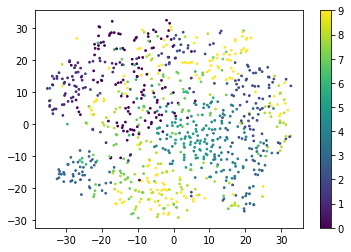

In [28]:
hidden=dense_model.layers[1](train_data).numpy()

from sklearn.manifold import TSNE
dr=TSNE()
embed_attentions=dr.fit_transform(hidden)

%matplotlib inline
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

scatter=ax.scatter(embed_attentions[:,0], embed_attentions[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

## Plot

In [34]:
#Data processed in excel by combining training and validation accuracy columns from individual training_log.csv"
import pandas as pd
SynthDataFolder="SynthData_10dim_clusternoise"
df=pd.read_csv(os.path.join("SynthData_10dim_clusternoise_results.csv"),
               index_col=False)

In [35]:
df.head()

,Epoch,LLDLwFW_valacc,LLDLwoFW_valacc,DenseModel_valacc,LLDLwFW_trainacc,LLDLwoFW_trainacc,DenseModel_trainacc
0,0,0.69,0.48,0.48,0.682222,0.486667,0.472222
1,1,0.70,0.49,0.52,0.757778,0.502222,0.517778
2,2,0.75,0.50,0.45,0.813333,0.535556,0.471111
3,3,0.76,0.53,0.48,0.821111,0.550000,0.534444
4,4,0.76,0.63,0.47,0.850000,0.577778,0.501111


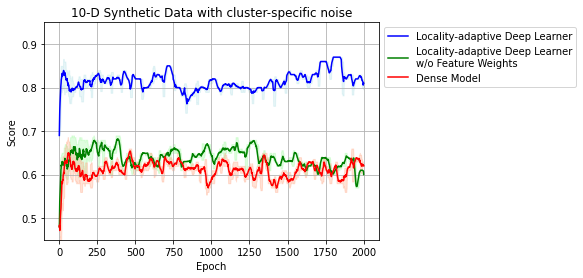

In [41]:
%matplotlib inline

import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch']+1)
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, i in enumerate(["LLDLwFW_valacc",
          "LLDLwoFW_valacc", 
          "DenseModel_valacc"
         ]):
    x_plot=df['Epoch']+1
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", "Locality-adaptive Deep Learner\nw/o Feature Weights", "Dense Model"], 
          bbox_to_anchor=(1,1))
ax.set_title("10-D Synthetic Data with cluster-specific noise")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)

## Random Forest

In [93]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
n_estimators_list=[200,500,1000]
n_repeats=10
random_seeds=range(n_repeats)
min_samples_list=list(range(1,11))
RF_results=[]

for n_estimator in n_estimators_list:
    for min_samples in min_samples_list:
        for i in range(n_repeats):
            np.random.seed(random_seeds[i])
            clf=ExtraTreesClassifier(n_estimators=n_estimator, 
                                     min_samples_leaf=min_samples,
                                     bootstrap=True, 
                                     oob_score=True, 
                                     class_weight="balanced_subsample")
            clf.fit(X_train, y_train)
            train_score=clf.score(X_train, y_train)
            test_score=clf.score(X_test, y_test)
            RF_results.append([n_estimator, min_samples, "train_accuracy", train_score])
            RF_results.append([n_estimator, min_samples, "test_accuracy", test_score])
        
RF_results=pd.DataFrame(RF_results, columns=["n_estimator", "min_samples_leaf", "metric", "score"])

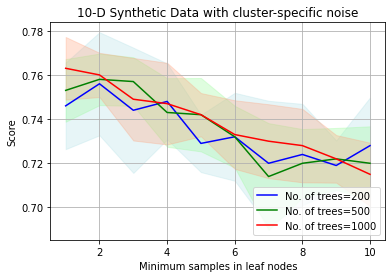

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_ave_LUbounds(df, x_col_name, percentiles=(10,90)):
    l,u=percentiles[0], percentiles[1]
    x_plot=np.unique(df[x_col_name])
    ave=[]
    lower=[]
    upper=[]
    if percentiles=='std':
        for x in x_plot:
            out=df[df[x_col_name]==x]['score']
            mean, std=np.mean(out), np.std(out)
            ave.append(mean)
            lower.append(mean-std)
            upper.append(mean+std)
        return x_plot, ave, lower, upper
    for x in x_plot:
        out=df[df[x_col_name]==x]['score']
        ave.append(np.mean(out))
        lower.append(np.percentile(out, l))
        upper.append(np.percentile(out, u))
    return x_plot, ave, lower, upper

fig,ax=plt.subplots()

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, n_estimator in enumerate(n_estimators_list):
    out_df=RF_results.query("n_estimator == @n_estimator & metric == 'test_accuracy' ")
    x_plot, ave, lower, upper=get_ave_LUbounds(out_df, x_col_name='min_samples_leaf',
                                               percentiles='std'
                                              )
    ax.plot(x_plot, ave, c=colors1[idx])
    ax.fill_between(x_plot, lower, upper, color=colors2[idx], alpha=0.3)

ax.set_xlabel("Minimum samples in leaf nodes")
ax.set_ylabel("Score")
# ax.set_ylim([0.45, 0.95])
ax.legend(["No. of trees="+str(i) for i in n_estimators_list], 
          loc=("lower right"))
ax.set_title("10-D Synthetic Data with cluster-specific noise")

plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_RF")
# plt.savefig(savefile)

## XGBoost

In [8]:
from xgboost import XGBClassifier
n_estimators_list=[200,500,1000]
n_repeats=3
random_seeds=range(n_repeats)
gamma_list=[0.00001,0.00003,0.0001,0.0003, 0.001, 0.003, 0.01,0.03, 0.1,0.3]
xgb_results=[]
scale_pos_weight= (len(y_train)-np.sum(y_train))/np.sum(y_train) #Ratio of number of negatives to number of positives


for n_estimators in n_estimators_list:
    for gamma in gamma_list:
        for i in range(n_repeats):
            xgb_clf=XGBClassifier(n_estimators=n_estimators,
                                  gamma=gamma,
                                  max_depth=20,
                                  scale_pos_weight=scale_pos_weight,
                                  use_label_encoder=False, 
                                  eval_metric='logloss',
                                  seed=random_seeds[i]
                                 )
            xgb_clf.fit(X_train, y_train)
            train_score=xgb_clf.score(X_train, y_train)
            test_score=xgb_clf.score(X_test, y_test)
            xgb_results.append([n_estimators, gamma, "train_accuracy", train_score])
            xgb_results.append([n_estimators, gamma, "test_accuracy", test_score])
            del xgb_clf
xgb_results=pd.DataFrame(xgb_results, columns=["n_estimator", "gamma", "metric", "score"])

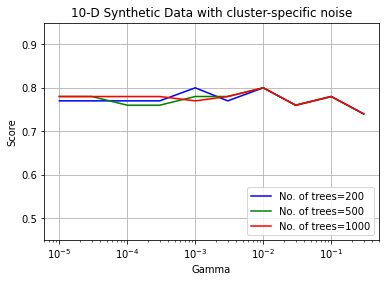

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_ave_LUbounds(df, x_col_name, percentiles=(10,90)):
    l,u=percentiles[0], percentiles[1]
    x_plot=np.unique(df[x_col_name])
    ave=[]
    lower=[]
    upper=[]
    if percentiles=='std':
        for x in x_plot:
            out=df[df[x_col_name]==x]['score']
            mean, std=np.mean(out), np.std(out)
            ave.append(mean)
            lower.append(mean-std)
            upper.append(mean+std)
        return x_plot, ave, lower, upper
    for x in x_plot:
        out=df[df[x_col_name]==x]['score']
        ave.append(np.mean(out))
        lower.append(np.percentile(out, l))
        upper.append(np.percentile(out, u))
    return x_plot, ave, lower, upper

fig,ax=plt.subplots()

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, n_estimator in enumerate(n_estimators_list):
    out_df=xgb_results.query("n_estimator == @n_estimator & metric == 'test_accuracy' ")
    x_plot, ave, lower, upper=get_ave_LUbounds(out_df, x_col_name='gamma',
                                               percentiles='std'
                                              )
    ax.plot(x_plot, ave, c=colors1[idx])
    ax.fill_between(x_plot, lower, upper, color=colors2[idx], alpha=0.3)

ax.set_xlabel("Gamma")
ax.set_ylabel("Score")
# ax.set_ylim([0.45, 0.95])
ax.legend(["No. of trees="+str(i) for i in n_estimators_list], 
          loc=("lower right"))
ax.set_title("10-D Synthetic Data with cluster-specific noise")

ax.set_xscale("log")
ax.set_ylim((0.45,0.95))
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_RF")
# plt.savefig(savefile)

In [10]:
xgb_results[xgb_results['metric']=="test_accuracy"]

,n_estimator,gamma,metric,score
1,200,0.00001,test_accuracy,0.77
3,200,0.00001,test_accuracy,0.77
5,200,0.00001,test_accuracy,0.77
7,200,0.00003,test_accuracy,0.77
9,200,0.00003,test_accuracy,0.77
...,...,...,...,...
171,1000,0.10000,test_accuracy,0.78
173,1000,0.10000,test_accuracy,0.78
175,1000,0.30000,test_accuracy,0.74
177,1000,0.30000,test_accuracy,0.74


# Trying out Similarity Batching 

In [281]:
#Just create tensorflow function and call it _on_epoch end
    Args:
      variant_tensor: The variant-dtype Tensor associated with the Dataset. This
        Tensor will be a captured input to functions which use the Dataset, and
        is used by saving code to identify the corresponding _VariantTracker.
      resource_creator: A zero-argument function which creates a new
        variant-dtype Tensor. This function will be included in SavedModels and
        run to re-create the Dataset's variant Tensor on restore.

In [ ]:
class UnaryDataset(DatasetV2):
  """Abstract class representing a dataset with one input."""

  def __init__(self, input_dataset, variant_tensor):
    self._input_dataset = input_dataset
    super(UnaryDataset, self).__init__(variant_tensor)

  def _inputs(self):
    return [self._input_dataset]

In [264]:
Sh_ds._variant_tensor_attr?

In [267]:
print(Sh_ds._variant_tensor_attr)

tf.Tensor(<unprintable>, shape=(), dtype=variant)


In [39]:
from tensorflow.python.data.ops.dataset_ops import UnaryDataset
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

class SimilarityBatchingDataset():
    def __init__(self, 
                 numpy_dataset,
                 numpy_targets,                 
                 attentions,
                 n_batch=8,
                 clusterer_kwargs={"n_clusters":None,
                                   "affinity":"cosine", 
                                   "linkage":"average"
                                  },
                 use_inter_op_parallelism=True,
                 preserve_cardinality=False,
                 use_legacy_function=False,
                 **kwargs
                ):
        self.numpy_dataset=numpy_dataset
        self.numpy_targets=numpy_targets
        self.attentions=attentions
        self.n_batch=n_batch
        self.clusterer_kwargs=clusterer_kwargs
        self._use_inter_op_parallelism=use_inter_op_parallelism
        self._preserve_cardinality=preserve_cardinality
        self._use_legacy_function=use_legacy_function
    
    

    def _partitions(self):
        #Set n_clusters if not initialized
        if self.clusterer_kwargs.get("n_clusters") is None:
            self.clusterer_kwargs["n_clusters"]=20
        
        clusterer=AgglomerativeClustering(**self.clusterer_kwargs)
        clusterer.fit(self.attentions)
        cl_labels=clusterer.labels_
        unique,counts=np.unique(cl_labels, return_counts=True)
        print(f"Fitted {len(unique)} clusters with distribution {np.sort(counts)[::-1]}")
        #Remember to shuffle partitions
        partitions=[np.where(cl_labels==i)[0] for i in np.unique(cl_labels)]
        m=len(partitions)
        rand_order=np.random.choice(range(m), size=m, replace=False)
        partitions=[partitions[i] for i in rand_order]
        
        return partitions

    def get_rearranged_tensor(self):
        arr=np.empty_like(self.numpy_dataset)
        arr_targets=np.empty_like(self.numpy_targets)
        self.partitions=self._partitions()
        ptr=0
        for p in self.partitions:
            arr[ptr:ptr+len(p)]=self.numpy_dataset[p,:]
            arr_targets[ptr:ptr+len(p)]=self.numpy_targets[p,:]
            ptr+=len(p)
        return arr, arr_targets
    
#     def get_similarity_batched_dataset(self):
#         arr=np.empty_like(self.numpy_dataset)
#         self.partitions=self._partitions()
#         ptr=0
#         for p in self.partitions:
#             arr[ptr:ptr+len(p)]=self.numpy_dataset[p,:]
#             ptr+=len(p)
#         ds=tf.data.Dataset.from_tensor_slices(arr)
#         return ds.batch(n_batch)
            
        
        
        

In [40]:
attentions=LSwFW_model.layers[1](train_tensor).numpy()
simbatched=SimilarityBatchingDataset(
    train_data,
    train_targets,
    attentions,
)
rearranged_train_data, rearranged_train_targets=simbatched.get_rearranged_tensor()

Fitted 20 clusters with distribution [232 104  93  80  76  66  59  51  41  36  30  16   5   4   2   1   1   1
   1   1]


In [61]:
LSwFW_model.optimizer.lr.assign(0.001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.001>

In [64]:
np.random.seed(0)

#For a trained LSwFW_model (n_epochs=200; shuffling) 
checkpoint_path=os.path.join("210210_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_label" )
LSwFW_model.load_weights(checkpoint_path)

simbatched_checkpoint_path=os.path.join("210210_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_simBatched" )
try:
    os.mkdir(simbatched_checkpoint_path)
except:
    pass

#Set callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=simbatched_checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='max',
                     
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)
csv_filename = os.path.join(simbatched_checkpoint_path,
                            "training_log_simBatched_lr0_001.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

#Assign learning rate
LSwFW_model.optimizer.lr.assign(0.001)

n_epoch=1000
for i in range(n_epoch):

    #Set training tensors
    attentions=LSwFW_model.layers[1](train_tensor).numpy()
    simbatched=SimilarityBatchingDataset(
        train_tensor,
        train_targets,
        attentions,
    )
    rearranged_train_tensor, rearranged_train_targets=simbatched.get_rearranged_tensor()
    
    #Fit model
    LSwFW_model.fit(rearranged_train_tensor, 
                rearranged_train_targets,
                epochs=1,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Fitted 20 clusters with distribution [132 120 118 108  89  66  63  51  44  33  24  16  14   8   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0555 - accuracy: 0.9889 - val_loss: 0.9279 - val_accuracy: 0.8800

Epoch 00001: val_accuracy improved from -inf to 0.88000, saving model to 210210_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatched
Fitted 20 clusters with distribution [153 132 126 110  86  66  62  52  34  24  18  15   7   4   3   2   2   2
   1   1]
29/29 - 1s - loss: 0.0450 - accuracy: 0.9911 - val_loss: 0.9368 - val_accuracy: 0.8900

Epoch 00001: val_accuracy improved from 0.88000 to 0.89000, saving model to 210210_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatched
Fitted 20 clusters with distribution [153 132 126 111  93  89  61  51  34  12  11   7   4   4   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0397 - accuracy: 0.9911 - val_loss: 0.9473 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [132 128 112 108  97  89  61  50  34  24  20  14   8   7   5   4   3   2
   1   1]
29/29 - 1s - loss: 0.0257 - accuracy: 0.9989 - val_loss: 1.0872 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [132 128 112 108  97  89  61  50  34  24  20  14   8   7   5   4   3   2
   1   1]
29/29 - 1s - loss: 0.0255 - accuracy: 0.9989 - val_loss: 1.0898 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [132 128 112 108  97  89  61  50  34  24  20  14   8   7   5   4   3   2
   1   1]
29/29 - 1s - loss: 0.0254 - accuracy: 0.9989 - val_loss: 1.0946 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [132 128 112 108 102  89  56  50  34  24  20  14   8   7   5   4   3   2
   1   1]
29/29 - 1s - loss: 0.0252 - accurac

29/29 - 1s - loss: 0.0222 - accuracy: 0.9989 - val_loss: 1.1793 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [145 132 114 109  97  95  59  51  33  20  12   8   8   5   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0219 - accuracy: 1.0000 - val_loss: 1.1811 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [138 132 114 109 104  95  59  51  33  20  12   8   8   5   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0220 - accuracy: 0.9989 - val_loss: 1.1832 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [138 132 120 109 104  95  53  51  33  20  12   8   8   5   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0220 - accuracy: 1.0000 - val_loss: 1.1896 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 132 120 104 102  95  53  5


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 130 121 119 103  98  52  51  33  11  10   8   5   4   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0194 - accuracy: 1.0000 - val_loss: 1.2700 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 130 121 119 103  98  52  51  33  11  10   8   5   4   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0196 - accuracy: 1.0000 - val_loss: 1.2704 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 130 121 119 103  98  52  51  33  11  10   8   5   4   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0192 - accuracy: 1.0000 - val_loss: 1.2729 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 130 121 119 103  98  52  51  33  11  10   8   5   4   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0192 - accurac

29/29 - 1s - loss: 0.0168 - accuracy: 1.0000 - val_loss: 1.3071 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 131 120  98  94  81  52  51  33  28  28  11   8   8   6   3   3   2
   1   1]
29/29 - 1s - loss: 0.0167 - accuracy: 1.0000 - val_loss: 1.3108 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 131 112 108  98  94  60  51  33  28  11   8   8   6   3   2   2   2
   1   1]
29/29 - 1s - loss: 0.0166 - accuracy: 1.0000 - val_loss: 1.3087 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 131 112 108  98  94  60  51  33  28  11   8   8   6   3   2   2   2
   1   1]
29/29 - 1s - loss: 0.0165 - accuracy: 1.0000 - val_loss: 1.3095 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 131 112 104  98  94  60  5


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 138 120 107  98  94  52  52  31  21  11   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0139 - accuracy: 1.0000 - val_loss: 1.3211 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 138 116 104  98  97  56  52  31  21  11   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0138 - accuracy: 1.0000 - val_loss: 1.3202 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 138 116 104  98  97  56  52  31  21  11   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0137 - accuracy: 1.0000 - val_loss: 1.3205 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [141 138 120 107  98  94  52  52  31  21  11   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0136 - accurac

29/29 - 1s - loss: 0.0110 - accuracy: 1.0000 - val_loss: 1.3121 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 129 123 115  99  93  52  38  31  28  14   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0109 - accuracy: 1.0000 - val_loss: 1.3118 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 129 123 115  99  93  52  38  31  28  14   8   8   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0108 - accuracy: 1.0000 - val_loss: 1.3074 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 123 115  99  91  70  66  52  38  31  26  14   8   8   6   3   2   2
   2   1]
29/29 - 1s - loss: 0.0107 - accuracy: 1.0000 - val_loss: 1.3037 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [143 123 115  99  91  70  66  5


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [138 128 111 106  97  95  50  41  36  31  17  15   9   8   5   4   3   2
   2   2]
29/29 - 1s - loss: 0.0688 - accuracy: 0.9822 - val_loss: 1.1153 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [135 131 117 105  99  93  57  48  31  23  18  10   9   9   5   3   2   2
   2   1]
29/29 - 1s - loss: 0.0359 - accuracy: 0.9922 - val_loss: 1.0555 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [140 128 107 103  98  93  49  44  31  25  22  11  11  10  10   8   4   3
   2   1]
29/29 - 1s - loss: 0.0145 - accuracy: 0.9989 - val_loss: 1.0303 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [140 128 107 105  98  98  49  45  31  25  22  10   9   9   8   5   4   3
   2   2]
29/29 - 1s - loss: 0.0113 - accurac

29/29 - 1s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 1.1137 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [140 127 105 105 103  97  51  45  31  25  18  11  10   9   8   7   3   2
   2   1]
29/29 - 1s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 1.1154 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [134 131 107 103 102  97  51  45  31  25  18  11  11  10   8   7   3   3
   2   1]
29/29 - 1s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 1.1170 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [134 131 107 106 102  97  51  45  31  25  18  11  11  10   7   5   3   3
   2   1]
29/29 - 1s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 1.1191 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [134 131 107 106 102  97  51  4


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 113 105 102  97  90  55  51  31  18  15   9   8   8   7   4   3   2
   2   2]
29/29 - 1s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 1.1637 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 113 105 102  97  90  55  51  31  18  15   9   8   8   7   4   3   2
   2   2]
29/29 - 1s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 1.1708 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 116 106 102  97  86  55  51  31  20  15   9   8   8   6   3   3   2
   2   2]
29/29 - 1s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 1.1740 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 116 106 102  97  86  55  51  31  20  15   9   8   8   6   3   3   2
   2   2]
29/29 - 1s - loss: 0.0078 - accurac

29/29 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 1.2035 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [185 113 110 102  97  95  51  44  31  26   9   9   9   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 1.2055 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [185 113 104 100  97  95  51  44  31  26  10   9   9   9   6   3   3   2
   2   1]
29/29 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 1.2045 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [185 113 113  99  97  95  51  44  31  26   9   9   9   6   3   3   2   2
   2   1]
29/29 - 1s - loss: 0.0072 - accuracy: 1.0000 - val_loss: 1.2074 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [185 109 108  99  97  95  51  4


Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 119 118  98  92  88  51  50  30  23  13  10   9   7   3   3   2   2
   2   2]
29/29 - 1s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.2253 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 118 118  98  92  88  51  51  30  23  13  10   9   7   3   3   2   2
   2   2]
29/29 - 1s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.2265 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 118 118  98  92  88  51  51  30  23  13  10   9   7   3   3   2   2
   2   2]
29/29 - 1s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.2251 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [178 118 118  98  92  88  51  51  30  23  13  10   9   7   3   3   2   2
   2   2]
29/29 - 1s - loss: 0.0064 - accurac

29/29 - 1s - loss: 0.1093 - accuracy: 0.9867 - val_loss: 1.1305 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [177 130 103 101  66  61  60  53  51  30  16  10  10   9   8   6   3   2
   2   2]
29/29 - 1s - loss: 0.0703 - accuracy: 0.9822 - val_loss: 1.4773 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [176 130 103  87  66  65  62  60  32  29  28  23   9   8   8   6   3   3
   1   1]
29/29 - 1s - loss: 0.0929 - accuracy: 0.9733 - val_loss: 1.0366 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [176 132 106 100  66  55  53  51  44  32  22  21  12   8   7   7   3   2
   2   1]
29/29 - 1s - loss: 0.0467 - accuracy: 0.9856 - val_loss: 1.1042 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
Fitted 20 clusters with distribution [177 125 118 106  66  51  51  4

29/29 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.0518 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 105  98  93  73  54  54  52  51  43  30  24  22   8   8   3   2   2
   1   1]
29/29 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.0528 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 105  98  93  73  54  54  52  51  43  30  24  22   8   8   3   2   2
   1   1]
29/29 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.0555 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 105  98  93  73  55  54  52  51  42  30  24  22   8   8   3   2   2
   1   1]
29/29 - 1s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.0556 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 105  98  93  73  55  54  5


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 124 106  98  93  52  51  49  46  30  24  21   8   8   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.1003 - val_accuracy: 0.9000

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 124 106  98  93  52  51  49  46  30  24  21   8   8   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.1007 - val_accuracy: 0.9000

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 124 106  98  93  52  51  49  46  30  24  21   8   8   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.1035 - val_accuracy: 0.9000

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 124 106  98  93  52  51  49  46  30  24  21   8   8   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0058 - accurac

29/29 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.1330 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 124 104  66  52  50  41  36  33  30  22  11   9   8   4   3   2
   2   1]
29/29 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.1303 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 124 104  66  52  50  41  36  33  30  22  11   9   8   4   3   2
   2   1]
29/29 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.1310 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 124 104  66  52  50  41  36  33  30  22  11   9   8   4   3   2
   2   1]
29/29 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.1328 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 124 104  66  52  50  4


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 148 119 103  51  50  46  45  36  33  30  23  12   8   6   4   4   4
   1   1]
29/29 - 1s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.1481 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 148 119 103  51  50  46  45  36  33  30  23  12   8   6   4   4   4
   1   1]
29/29 - 1s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.1492 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 148 119 103  51  50  46  45  36  33  30  23  12   8   6   4   4   4
   1   1]
29/29 - 1s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.1491 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 148 119 103  51  50  46  45  36  33  30  23  12   8   6   4   4   4
   1   1]
29/29 - 1s - loss: 0.0050 - accurac

29/29 - 1s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.1704 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 148 121 106  92  50  44  37  32  30  16  12   8   8   6   4   4   2
   2   1]
29/29 - 1s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.1702 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 148 121 106  92  50  44  37  32  30  16  12   8   8   6   4   4   2
   2   1]
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.1735 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 148 121 106  92  50  44  37  32  30  16  12   8   8   6   4   4   2
   2   1]
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.1690 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 148 118 106  92  51  43  3


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 131 130 111  94  66  51  39  32  31  12   8   5   3   2   2   2   2
   2   1]
29/29 - 1s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.1187 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 131 130 111  94  66  51  39  32  31  12   8   5   3   2   2   2   2
   2   1]
29/29 - 1s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.1250 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 121 118 115 101  93  51  39  31  15  12   9   5   3   2   2   2   2
   2   1]
29/29 - 1s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.1313 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 121 118 115 101  93  51  39  31  15  12   9   5   3   2   2   2   2
   2   1]
29/29 - 1s - loss: 0.0052 - accurac

29/29 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.2247 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 115 113 100  94  51  39  31  15  12   9   9   5   4   3   2   2
   2   1]
29/29 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.2295 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 113 100  94  66  51  49  39  31  15  12   9   5   4   3   2   2
   2   1]
29/29 - 1s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.2315 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 113 100  94  66  51  49  39  31  15  12   9   5   4   3   2   2
   2   1]
29/29 - 1s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.2348 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 125 113 100  94  66  51  4


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 114 101  88  66  52  49  35  31  15  15  12   6   6   5   5   4
   2   1]
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2877 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 114 101  88  66  52  49  35  31  15  15  12   6   6   5   5   4
   2   1]
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2920 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 116 114  87  66  51  40  32  31  15  12   6   6   5   5   4   2
   1   1]
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2923 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 116 114  87  66  51  40  31  31  15  12   7   6   5   5   4   2
   1   1]
29/29 - 1s - loss: 0.0045 - accurac

29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3380 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 118 115  97  85  66  51  49  40  31  15  15  12   6   6   5   4   4
   2   2]
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3397 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 115  97  87  66  51  49  40  31  15  15  12   6   6   5   4   4
   2   2]
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3384 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 115  97  87  66  51  49  40  31  15  15  12   6   6   5   4   4
   2   2]
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3386 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 116 115  97  87  66  51  4


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 116 111  92  55  51  46  31  16  14  12   8   6   5   4   3   2
   2   2]
29/29 - 1s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.3827 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 116 111  92  55  51  46  31  16  14  12   8   6   5   4   3   2
   2   2]
29/29 - 1s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.3863 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 116 111  92  55  51  46  31  16  14  12   8   6   5   4   3   2
   2   2]
29/29 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.3833 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 116 111  92  55  51  46  31  16  14  12   8   6   5   4   3   2
   2   2]
29/29 - 1s - loss: 0.0039 - accurac

29/29 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.4299 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 106 104  90  53  53  51  30  22  17  12  11   6   5   5   4   3
   2   2]
29/29 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.4334 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 106 104  90  53  53  51  30  22  17  12  11   6   5   5   4   3
   2   2]
29/29 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.4388 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 106 104  90  53  53  51  30  22  17  12  11   6   5   5   4   3
   2   2]
29/29 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.4256 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 115 115  90  53  51  4


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 123 103  98  94  90  53  51  30  20  16  13   7   6   6   5   4   3
   2   1]
29/29 - 1s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.4624 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 119 103  92  53  52  46  30  26  20   7   6   6   5   3   3   2
   2   1]
29/29 - 1s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.4534 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 149 118 103  92  53  53  52  30  26  20   6   6   5   3   3   2   2
   1   1]
29/29 - 1s - loss: 0.0292 - accuracy: 0.9956 - val_loss: 1.2493 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [176 149 119 104 104  53  53  30  30  24  22  12   6   5   4   3   2   2
   1   1]
29/29 - 1s - loss: 0.0799 - accurac

29/29 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.1102 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 124 119  82  66  54  49  30  16  15  11   8   8   3   2   2   2
   2   1]
29/29 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.1046 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 124 121  82  66  54  49  30  16  15  10   8   8   3   2   2   2
   1   1]
29/29 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.1118 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 124 121  82  66  54  49  30  16  15  10   8   8   3   2   2   2
   1   1]
29/29 - 1s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.1290 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [177 129 124 112  82  66  54  3


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 126 117 111  96  65  54  35  31  30  15  10  10   9   8   2   2   2
   1   1]
29/29 - 1s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.1772 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 126 117 111  96  65  54  35  31  30  15  10  10   9   8   2   2   2
   1   1]
29/29 - 1s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.1783 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 117 115  96  65  54  35  31  30  13  11  10   8   6   3   2   2
   1   1]
29/29 - 1s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.1778 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 117 115  96  65  54  35  31  30  13  11  10   8   6   3   2   2
   1   1]
29/29 - 1s - loss: 0.0035 - accurac

29/29 - 1s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.2051 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 114 109  93  65  54  35  31  31  15  14  12   8   6   5   3   2
   2   1]
29/29 - 1s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.2117 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 114 109  93  65  54  35  31  31  15  14  12   8   6   5   3   2
   2   1]
29/29 - 1s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.2134 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 114 109  93  65  54  35  31  31  15  14  12   8   6   5   3   2
   2   1]
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2105 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 125 114 109  93  65  54  3


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 118 115 110  91  65  54  35  31  31  15  13  12   9   8   8   5   2
   2   1]
29/29 - 1s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.2496 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 118 115 110  91  65  54  35  31  31  15  13  12   9   8   8   5   2
   2   1]
29/29 - 1s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.2474 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 118 115 110  91  65  54  35  31  31  15  13  12   9   8   8   5   2
   2   1]
29/29 - 1s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.2459 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [175 118 115 110  91  65  54  35  31  31  15  13  12   9   8   8   5   2
   2   1]
29/29 - 1s - loss: 0.0032 - accurac

29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2774 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 126 118 116 104  66  54  49  31  17  11   8   8   5   5   2   2   2
   1   1]
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2807 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 126 116 111 106  66  54  49  31  17  13  11   8   5   5   2   2   2
   1   1]
29/29 - 1s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.2822 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 126 116 111 106  66  54  49  31  17  13  11   8   5   5   2   2   2
   1   1]
29/29 - 1s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.2805 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 126 118 116 104  66  54  4


Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 118 116 115 104  65  54  51  30  21  15   8   8   7   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.3011 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 118 116 115 104  65  54  51  30  21  15   8   8   7   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.3006 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 118 116 115 104  65  54  51  30  21  15   8   8   7   5   3   2   2
   1   1]
29/29 - 1s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2978 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 128 118 116 104  65  54  51  30  21   8   8   5   5   4   3   2   2
   1   1]
29/29 - 1s - loss: 0.0027 - accurac

29/29 - 1s - loss: 0.0062 - accuracy: 0.9989 - val_loss: 1.0165 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 117 115 109  98  93  53  48  30  23  11   7   6   4   4   3   2   1
   1   1]
29/29 - 1s - loss: 0.0060 - accuracy: 0.9989 - val_loss: 1.0440 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 117 115 109  98  93  53  48  30  23  11   7   6   4   4   3   2   1
   1   1]
29/29 - 1s - loss: 0.0058 - accuracy: 0.9989 - val_loss: 1.0184 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 125 117 115 109  66  53  48  30  23  11   7   6   4   4   3   2   1
   1   1]
29/29 - 1s - loss: 0.0062 - accuracy: 0.9989 - val_loss: 1.0528 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [174 125 118 115 113  66  51  4

In [65]:
np.random.seed(0)

#For a trained LSwFW_model (n_epochs=200; shuffling) 
checkpoint_path=os.path.join("210210_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_label" )
LSwFW_model.load_weights(checkpoint_path)

simbatched_checkpoint_path=os.path.join("210210_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_simBatched" )
try:
    os.mkdir(simbatched_checkpoint_path)
except:
    pass

#Set callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=simbatched_checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='max',
                     
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)
csv_filename = os.path.join(simbatched_checkpoint_path,
                            "training_log_NosimBatched_lr_0_001.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

#Assign learning rate
LSwFW_model.optimizer.lr.assign(0.001)

n_epoch=1000
for i in range(n_epoch):
    #No rearranging of tensors
    #Fit model
    LSwFW_model.fit(train_tensor, 
                train_targets,
                epochs=1,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

29/29 - 1s - loss: 0.0545 - accuracy: 0.9867 - val_loss: 0.9221 - val_accuracy: 0.8900

Epoch 00001: val_accuracy improved from -inf to 0.89000, saving model to 210210_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatched
29/29 - 1s - loss: 0.0433 - accuracy: 0.9933 - val_loss: 0.9312 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0396 - accuracy: 0.9933 - val_loss: 0.9443 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0388 - accuracy: 0.9933 - val_loss: 0.9630 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0372 - accuracy: 0.9933 - val_loss: 0.9682 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0357 - accuracy: 0.9956 - val_loss: 0.9714 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0341 - accuracy: 0.9944 - val_loss:

29/29 - 1s - loss: 0.0227 - accuracy: 0.9989 - val_loss: 1.1696 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0225 - accuracy: 0.9989 - val_loss: 1.1744 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0225 - accuracy: 0.9989 - val_loss: 1.1793 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.1820 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0222 - accuracy: 0.9989 - val_loss: 1.1843 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0222 - accuracy: 0.9989 - val_loss: 1.1886 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0220 - accuracy: 0.9989 - val_loss: 1.1906 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0176 - accuracy: 1.0000 - val_loss: 1.2900 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0176 - accuracy: 1.0000 - val_loss: 1.2909 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0175 - accuracy: 1.0000 - val_loss: 1.2921 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0174 - accuracy: 1.0000 - val_loss: 1.2930 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0173 - accuracy: 1.0000 - val_loss: 1.2966 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0172 - accuracy: 1.0000 - val_loss: 1.2975 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0171 - accuracy: 1.0000 - val_loss: 1.2949 - val_accuracy: 0.8600

29/29 - 1s - loss: 0.0125 - accuracy: 1.0000 - val_loss: 1.3388 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0124 - accuracy: 1.0000 - val_loss: 1.3425 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0123 - accuracy: 1.0000 - val_loss: 1.3408 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0122 - accuracy: 1.0000 - val_loss: 1.3397 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0121 - accuracy: 1.0000 - val_loss: 1.3351 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0120 - accuracy: 1.0000 - val_loss: 1.3390 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0119 - accuracy: 1.0000 - val_loss: 1.3358 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.1468 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.1482 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.1507 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.1531 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.1557 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.1571 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.1595 - val_accuracy: 0.8700

29/29 - 1s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.2232 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.2215 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.2235 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.2289 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.2283 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 1.2282 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 1.2334 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 1.1874 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 1.1955 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.1988 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.2026 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.2146 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.2120 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.2180 - val_accuracy: 0.8500

29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3245 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3295 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3290 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3300 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3291 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3289 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.3311 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 1.0373 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.0416 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.0448 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.0598 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.0625 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.0652 - val_accuracy: 0.9000

Epoch 00001: val_accuracy improved from 0.89000 to 0.90000, saving model to 210210_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatch


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1560 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1539 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1542 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1558 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1553 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1555 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1653 - val_accuracy: 0.8700

29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.1666 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1685 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1705 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1594 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1681 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1676 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1679 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0135 - accuracy: 0.9956 - val_loss: 1.1348 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0114 - accuracy: 0.9967 - val_loss: 1.1429 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0113 - accuracy: 0.9967 - val_loss: 1.1764 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0222 - accuracy: 0.9944 - val_loss: 1.1309 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0166 - accuracy: 0.9944 - val_loss: 1.1327 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0085 - accuracy: 0.9989 - val_loss: 1.1477 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0078 - accuracy: 0.9989 - val_loss: 1.1641 - val_accuracy: 0.8500

29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3623 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3624 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3632 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3625 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3638 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3662 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3678 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.4265 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3791 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3644 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3662 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3717 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3710 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.3666 - val_accuracy: 0.8700

29/29 - 1s - loss: 0.0197 - accuracy: 0.9944 - val_loss: 1.1070 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0123 - accuracy: 0.9989 - val_loss: 1.1795 - val_accuracy: 0.8300

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0094 - accuracy: 0.9989 - val_loss: 1.1520 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0070 - accuracy: 0.9989 - val_loss: 1.1511 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0051 - accuracy: 0.9989 - val_loss: 1.1380 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.1247 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.1376 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2203 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2246 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2250 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2317 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2304 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2296 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2290 - val_accuracy: 0.8600

29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2863 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2818 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2864 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2864 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2718 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2826 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2895 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3559 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3526 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3648 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3544 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3592 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3601 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3518 - val_accuracy: 0.8400

In [73]:
#Data processed in excel by combining training and validation accuracy columns from individual training_log.csv"
import pandas as pd
SynthDataFolder="SynthData_10dim_clusternoise_AddBN"
df=pd.read_csv(os.path.join("SynthData10dim_results.csv"),
               index_col=False)

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


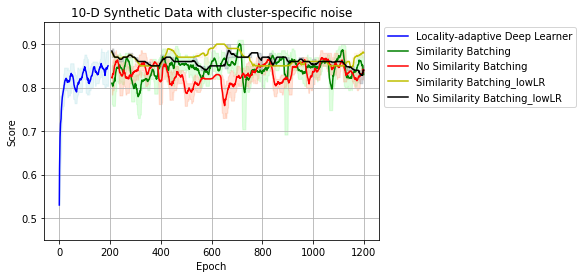

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch'])
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r","y","k"]
colors2=["powderblue","palegreen","lightsalmon","bisque","lightslategray"]
for idx, i in enumerate(["LLDLwFW_valacc",
#           "LLDLwoFW_valacc", 
#           "DenseModel_valacc"
                         "LLDLwFW_simBatched_valacc",
                         "LLDLwFW_NosimBatched_valacc",
                         "LLDLwFW_simBatched_lr_0_001_valacc",
                         "LLDLwFW_NosimBatched_lr_0_001_valacc"
         ]):
    x_plot=df['Epoch']
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", 
           "Similarity Batching",
           "No Similarity Batching",
           "Similarity Batching_lowLR",
           "No Similarity Batching_lowLR"
          ], 
          bbox_to_anchor=(1,1))
ax.set_title("10-D Synthetic Data with cluster-specific noise")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)

In [ ]:
#Try turning learning rate down to 0.001

In [ ]:
#Try on unbalanced dataset

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


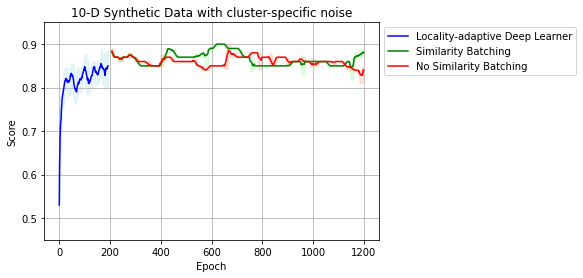

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch'])
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r","y","k"]
colors2=["powderblue","palegreen","lightsalmon","bisque","lightslategray"]
for idx, i in enumerate(["LLDLwFW_valacc",
#           "LLDLwoFW_valacc", 
#           "DenseModel_valacc"
#                          "LLDLwFW_simBatched_valacc",
#                          "LLDLwFW_NosimBatched_valacc",
                         "LLDLwFW_simBatched_lr_0_001_valacc",
                         "LLDLwFW_NosimBatched_lr_0_001_valacc"
         ]):
    x_plot=df['Epoch']
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", 
#            "Similarity Batching",
#            "No Similarity Batching",
           "Similarity Batching",
           "No Similarity Batching"
          ], 
          bbox_to_anchor=(1,1))
ax.set_title("10-D Synthetic Data with cluster-specific noise")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)